# 0.0 IMPORTS

In [5]:
import inflection
import math
import datetime
import random
import warnings
import pickle
import pandas              as pd
import numpy               as np
import seaborn             as sns
import xgboost             as xgb
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec


from IPython.core.display  import HTML
from IPython.display       import Image
from boruta                import BorutaPy
from tabulate              import tabulate
from sklearn.ensemble      import RandomForestRegressor
from flask                 import Flask, request, Response
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from scipy                 import stats         as ss

warnings.filterwarnings( 'ignore' )

## 0.2 Helper Functions

In [8]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    '''Esta função realiza validação cruzada k-fold para avaliar o desempenho de um modelo de machine learning.
    Ela divide os dados em conjuntos de treino e validação, treina o modelo, faz predições e calcula métricas de erro para cada iteração do k-fold.
    Input: dados de treino, número de folds (k), nome do modelo e o modelo em si.
    Output: DataFrame com métricas de desempenho médio e desvio padrão para o modelo especificado.
    '''
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training[ 'date' ].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training[ 'date' ].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training  = x_training[x_training[ 'date' ] < validation_start_date]
        validation  = x_training[ (x_training[ 'date' ] >= validation_start_date ) & (x_training[ 'date' ] <= validation_end_date) ]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = training.drop( ['date', 'sales'], axis=1 )
        yvalidation = training['sales']

        # model
        m = model.fit( xtraining, ytraining)

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each Kfold iteration
        mae_list.append( m_result[ 'MAE' ] )
        mape_list.append( m_result[ 'MAPE' ] )
        rmse_list.append( m_result[ 'RMSE' ] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2).astype( str ) }, index=[0] )



def ml_error( model_name, y, yhat ):
    '''Essa função ml_error calcula as métricas de erro - Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE)
    e Root Mean Squared Error (RMSE) - entre os valores reais (y) e os valores previstos (yhat) de um modelo de Machine Learning específico.

    Input:
    1. model_name: O nome do modelo.
    2. y: Os valores reais.
    3. yhat: Os valores previstos pelo modelo.

    Output:
    Retorna um DataFrame Pandas contendo as métricas de erro calculadas para o modelo especificado, incluindo MAE, MAPE e RMSE para as previsões desse
    modelo. Essas métricas são organizadas em um DataFrame com uma linha para cada modelo, facilitando a comparação entre diferentes modelos de Machine
    Learning.
    '''
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error ( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat) )

    return pd.DataFrame({ 'model_name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )

def cramer_v ( x, y ):
    '''# Etapas do V de Cramer
    # Encontrando a quantidade do 1 contra 1 das variáveis
    cm = pd.crosstab( a['state_holiday'], a['store_type'] ).values

    # Calculando V de Cramer. Fórmula: V = sqrt ((x2/n)/ min(r-1,k-1)).
    # sqrt: raiz quadrada
    # x2 é derivado do teste de qui-quadrado de pearson
    # n é o total geral de observações
    # r é o número de colunas
    # k é o número de linhas

    # Encontrando o qui-quadrado
    chi2 = ss.chi2_contingency( cm )[0]

    # Encontrando o n
    n = cm.sum()

    # Encontrando o r e o k
    r, k = cm.shape

    # V de Cramer. Ele vai de 0 a 1. Quanto mais perto de 0 menor a correlação. Quanto mais próximo de 1 mais forte a correlação.
    v = np.sqrt( (chi2/n) / ( min( k-1, r-1 ) ) )
    Input: duas variáveis categóricas x e y.
    A função calcula o coeficiente V de Cramer para medir a associação entre essas variáveis, realizando operações estatísticas,
    como a construção de tabelas de contingência, cálculos de qui-quadrado e aplicação da fórmula do coeficiente de associação.
    Output: um valor numérico que varia de 0 a 1, indicando a força da associação entre as variáveis x e y, onde valores próximos de 0
    sugerem uma correlação mais fraca, enquanto valores próximos de 1 indicam uma correlação mais forte.
    '''
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    '''Este código configura as opções de visualização para um ambiente Jupyter Notebook.
    Define o uso de gráficos inline, um estilo de plotagem específico (nesse caso, 'bmh'), tamanhos de fonte e de figura padronizados.
    Além disso, ajusta a exibição de DataFrames Pandas para evitar a quebra de linhas e para mostrar todas as colunas e linhas.
    Por fim, configura o ambiente Seaborn para melhorar a estética dos gráficos.

    Input: Não há input direto na função, pois ela configura o ambiente de visualização do Jupyter Notebook.

    Output: Não há output explícito, mas as configurações alteradas serão refletidas nos gráficos, no tamanho da fonte,
    na exibição de DataFrames e na estética das visualizações ao longo do notebook.
    '''
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    # configura o pandas para quantidade de casas decimeis
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [9]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [10]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

# merge (Unindo os arquivos a partir do store, coluna comun aos dois arquivoc, a fim de montar um tabelão com os dados de venda e as características da loja. LEmbre-se da união de tabelas no SQL)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 DESCRIÇÃO DOS DADOS (Passo 1)

In [11]:
# Cópia do DF - neste caso o meigraom fez pois não precisar rodar o código completo se der algum erro, apenas a seção
df1 = df_raw.copy()

## 1.1 Rename Columns

In [12]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# Renomeando as colunas com a função lambda

snakecase = lambda x: inflection.underscore(x)
# map vai mapear a função snakecase em todas as palavras da lista cols_old
cols_new = list ( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [13]:
print('Number of Rows: {}'.format (df1.shape[0]))
print('Number of Columns: {}'.format (df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [14]:
# alterando o tipo da coluna data de object para date
df1['date'] = pd.to_datetime( df1 ['date'] )

df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [15]:
# somando as linhas vazias

df_raw.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

## 1.5 Fillout NA

In [16]:
# competition_distance: distancia até um competidor
# max_value 20000 if math.isna(df1['competition_distance']) else df1 ['competition_distance'] - raciocínio
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )

# competition_open_since_month: data da última competição. Para os NA's copiar data da última venda
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

# promo2_since_week: data da continuidade da última promoção
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

# promo_interval: intervalo de meses em que apromoção 2 foi ativa. A ideia é criar uma coluna auxiliar dizendo sim ou não.
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna( 0 , inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] ==0 else 1 if x['month_map'] in x['promo_interval'].split ( ',' ) else 0, axis=1 )

In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [18]:
df1.sample(10).T

,738028,594839,666233,245841,350389,340706,358306,521563,986624,601342
store,684,215,249,134,1044,651,449,529,635,28
day_of_week,7,2,1,7,1,4,6,5,1,3
date,2013-09-08 00:00:00,2014-01-14 00:00:00,2013-11-11 00:00:00,2014-12-21 00:00:00,2014-09-01 00:00:00,2014-09-11 00:00:00,2014-08-23 00:00:00,2014-03-21 00:00:00,2013-01-28 00:00:00,2014-01-08 00:00:00
sales,0,3534,4508,0,9572,5741,7298,8734,3910,7620
customers,0,300,508,0,1094,759,1048,802,475,767
open,0,1,1,0,1,1,1,1,1,1
promo,0,0,0,0,1,0,0,1,0,1
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,0,0,0,0,1,0,1,0,0,0
store_type,d,d,d,a,c,a,a,d,a,a


## 1.6 Change Types

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [20]:
# Separando as colunas númericas
num_attributes = df1.select_dtypes( include=[ 'int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [21]:
# Central Tendence
ct1 = pd.DataFrame( num_attributes.apply ( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply ( np.median) ).T

# Dispercion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply ( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply (min) ).T
d3 = pd.DataFrame( num_attributes.apply (max) ).T
d4 = pd.DataFrame( num_attributes.apply (lambda x: (x.max() - x.min()) ) ).T
d5 = pd.DataFrame( num_attributes.apply (lambda x: x.skew () ) ).T
d6 = pd.DataFrame( num_attributes.apply (lambda x: x.kurtosis () ) ).T


#Concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = [ 'atributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,atributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


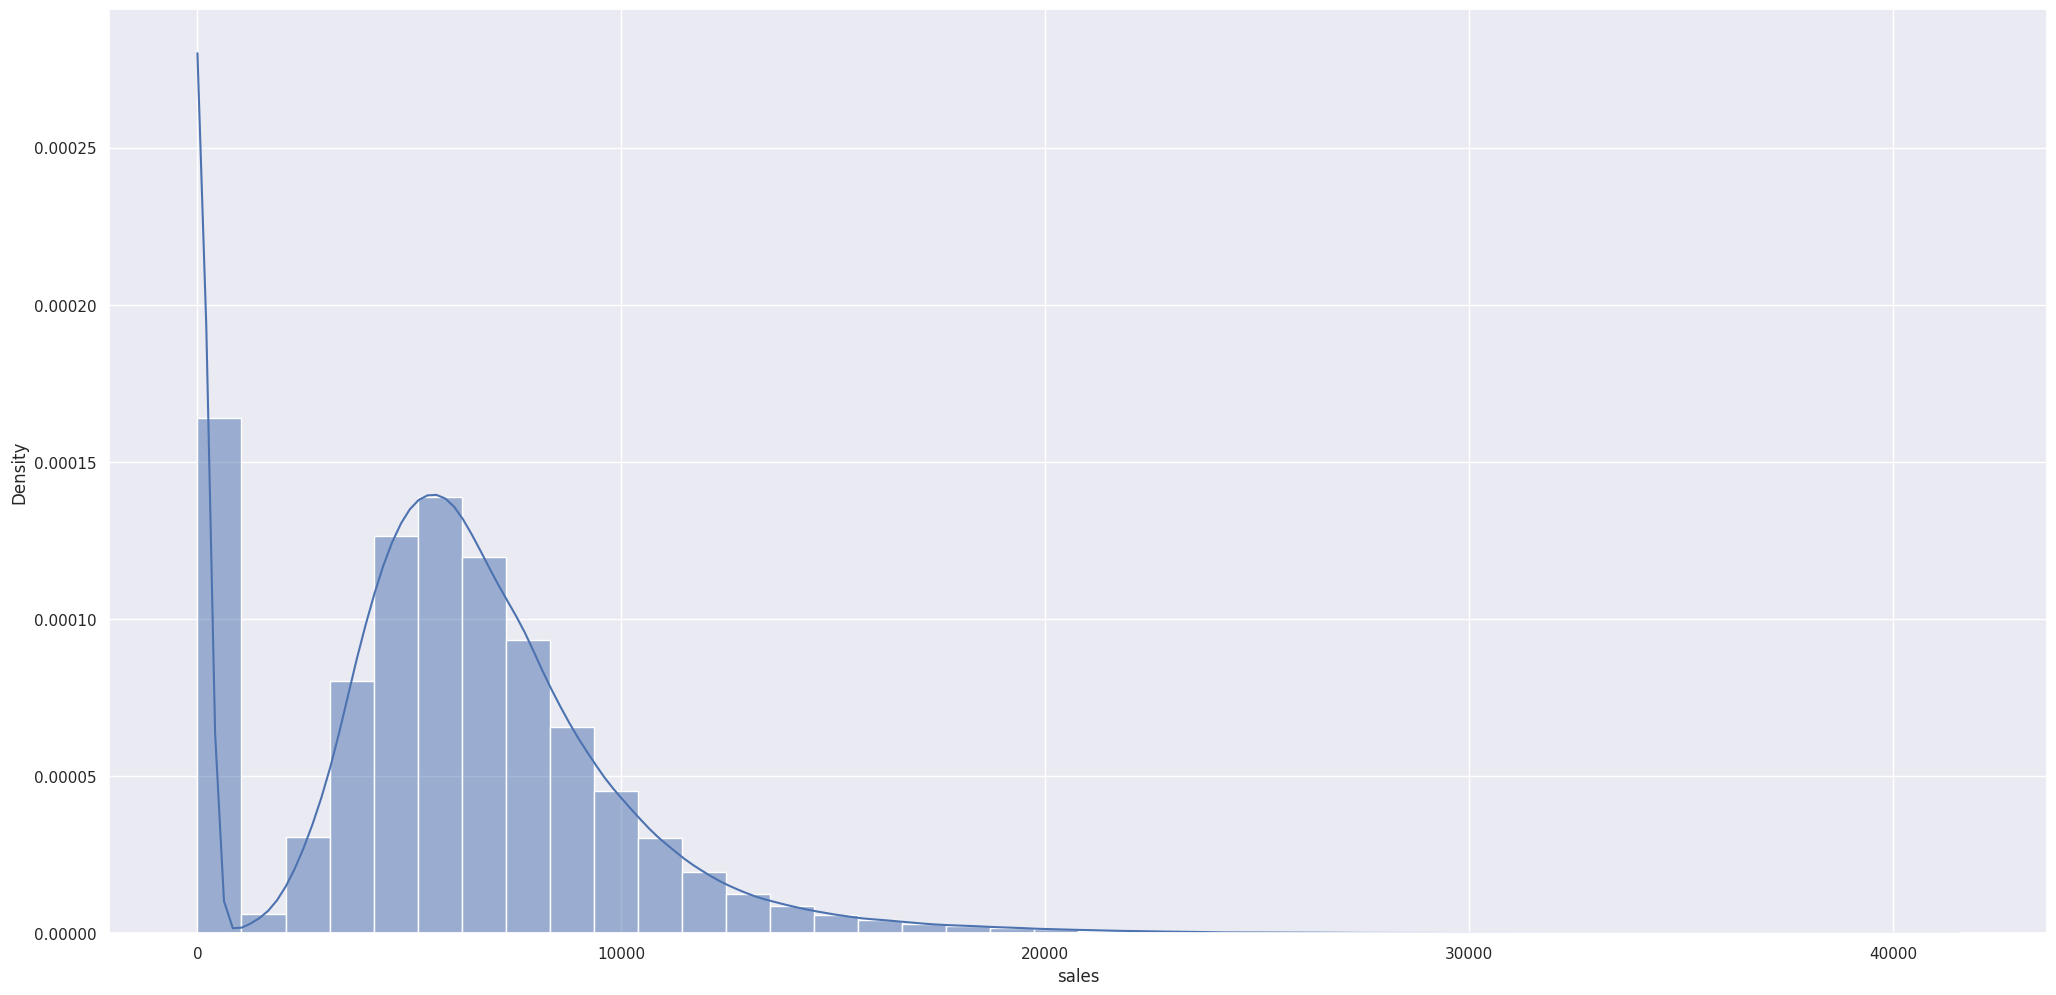

In [22]:
sns.histplot( df1['sales'], kde=True, stat="density" , bins=40 );

### 1.7.2 Categorical Attributes

In [23]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

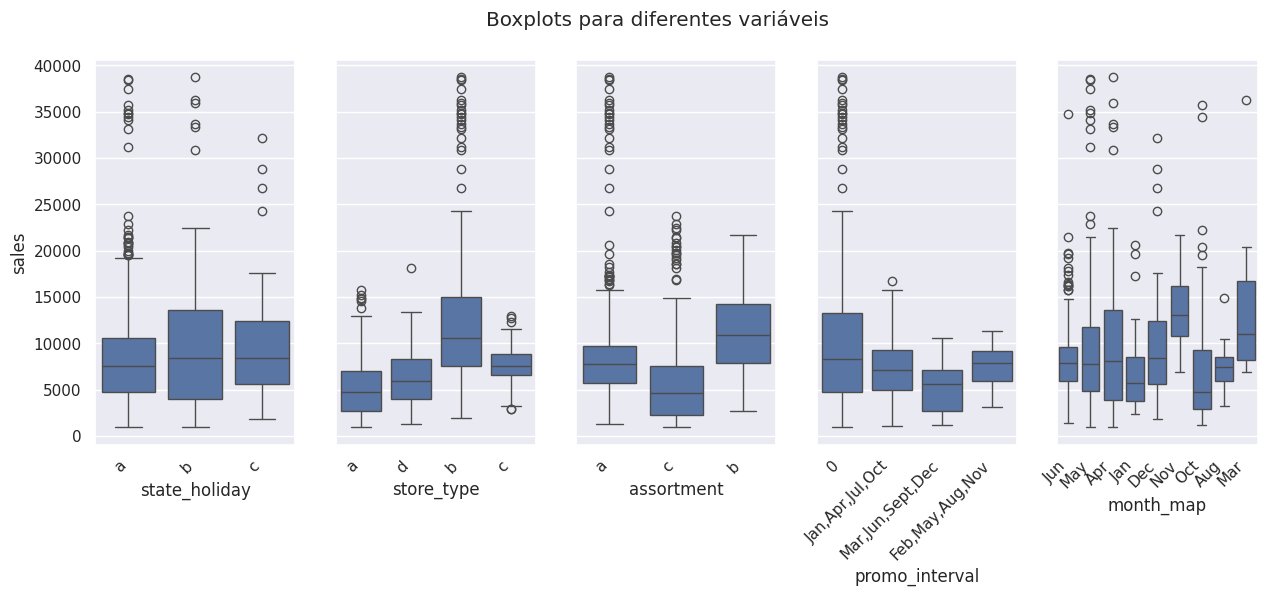

In [24]:
# Filtrando o dataset
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

# Configuração do subplot
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Boxplots
sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='store_type', y='sales', data=aux1, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='assortment', y='sales', data=aux1, ax=axes[2])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='promo_interval', y='sales', data=aux1, ax=axes[3])
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='month_map', y='sales', data=aux1, ax=axes[4])
axes[4].set_xticklabels(axes[4].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

# Ajusta o título do subplot
plt.suptitle('Boxplots para diferentes variáveis')

# Exibe o gráfico
plt.show()


# 2.0 FEATURE ENGINEERING (Passo 2)

In [25]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

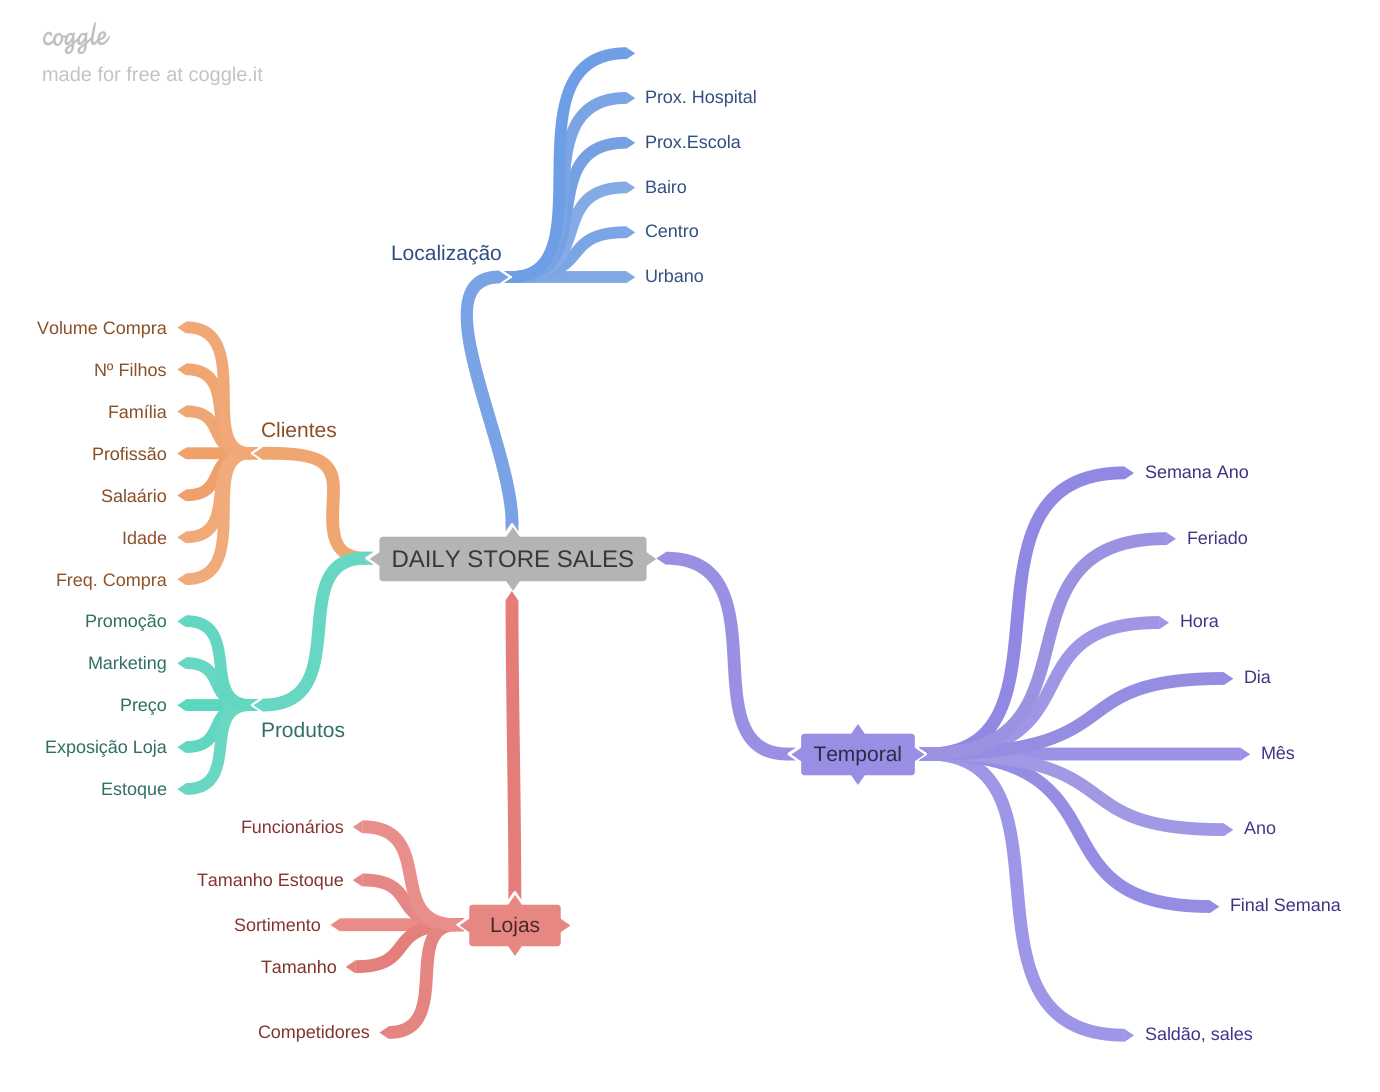

In [29]:
Image( 'img/MindMapHypothesis.png' )

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses da Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com estoque maior deveriam vender mais.

**3.** Lojas com maior sortimento deveriam vender mais.

**4.** Lojas maiores deveriam vender mais.

**5.** Lojas com menos competidores devereiam vender menos.

### 2.2.2 Hipóteses do Produto

**1.** Lojas com promoções deveriam vender mais.

**2.** Lojas que investem em marketing deveriam vender mais.

**3.** Lojas com produtos mais caros deveriam vender menos.

**4.** Lojas com produtos mais expostos vendem mais.

**5.** Lojas com poucos produtos em estoque deveriam vender menos.

**6.** Lojas com produtos mais baratos por mais tempos deveriam vender mais.

### 2.2.3 Hipóteses Temporal

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primieros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas com funcionamento superior a 10 horas diarias deveriam vender mais.

**5.** Lojas com menos saldão deveriam vender menos.

**6.** Lojas que abrem nas últimas 4 semanas do ano deveriam vender mais.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos devereiam vender menos.

**3.** Lojas com competidores a mais tempo devereiam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções censecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engineering

In [27]:
# Derivando variáveis

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.strftime( '%V' )

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime ( year=x['competition_open_since_year'], month=x['competition_open_since_month'] , day=1 ), axis=1 )
df2['competition_time_month']= ( ( df2['date'] - df2['competition_since'])/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply ( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extendend' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day' )



In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DAS VARIÁVEIS (Passo 3)

In [30]:
df3 = df2.copy()

In [31]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1 Filtragem das linhas

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extendend,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [33]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [34]:
cols_drop = [ 'customers', 'open', 'promo_interval', 'month_map' ]
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 ANÁLISE EXPLORATORIA DOS DADOS (Passo 4)

In [35]:
df4 = df3.copy()

   ## 4.1 Análise Univariada

### 4.1.1 Response Variable

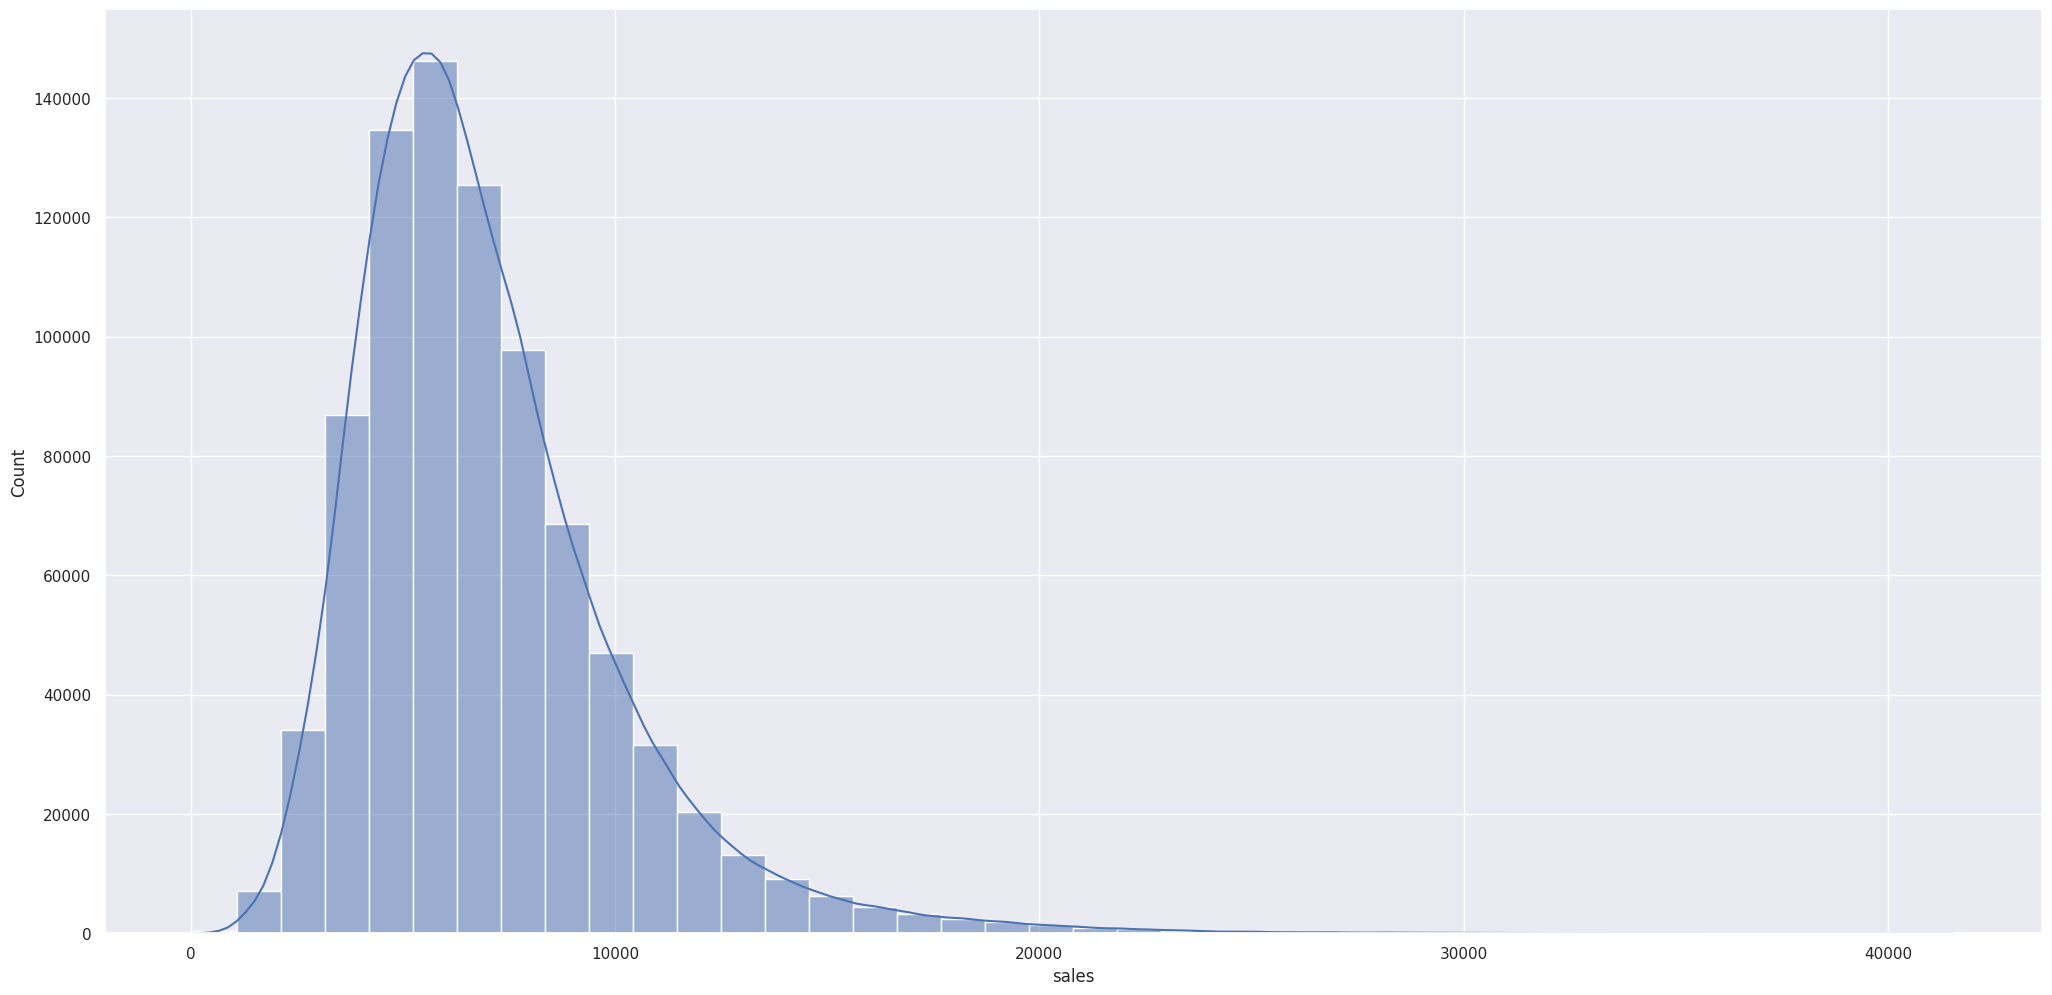

In [36]:
sns.histplot(df4['sales'], kde=True, bins=40 );

### 4.1.2 Numerical Variable

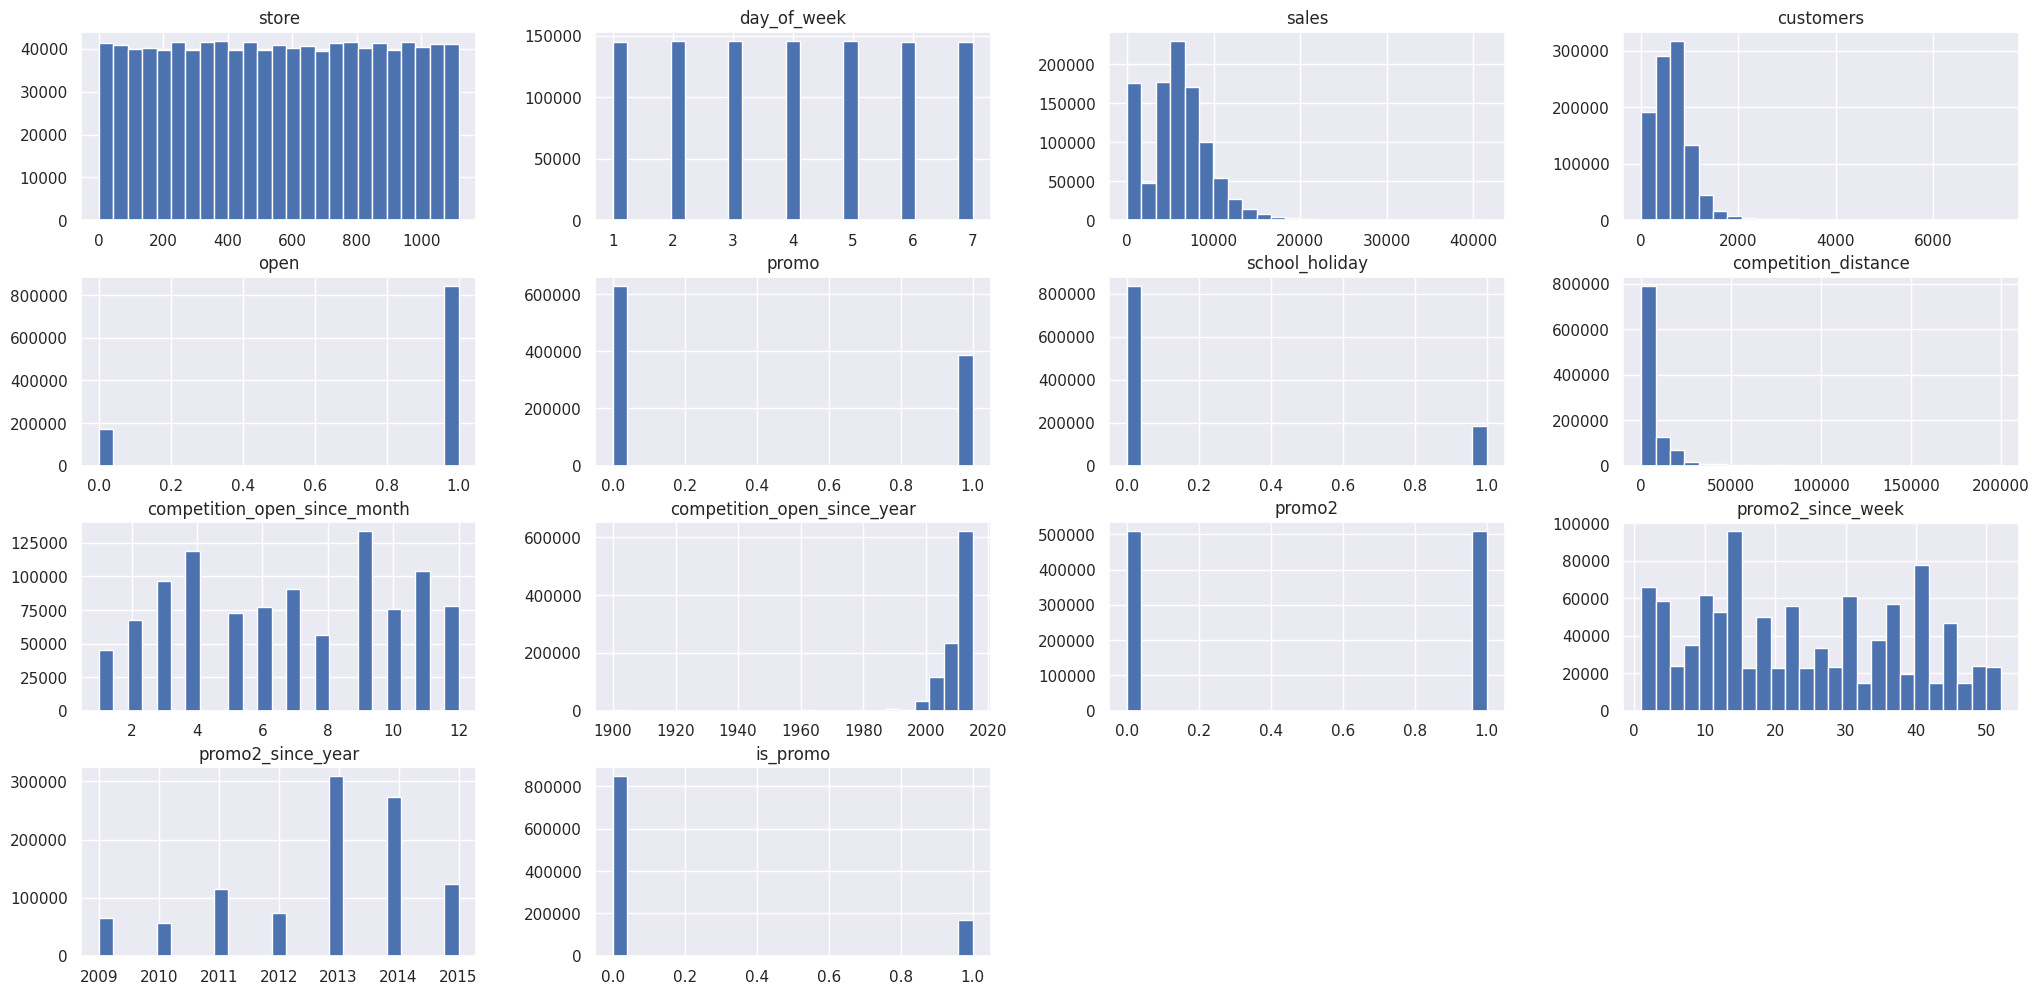

In [37]:
num_attributes.hist( bins=25 );

### 4.1.3 Categorical Variable

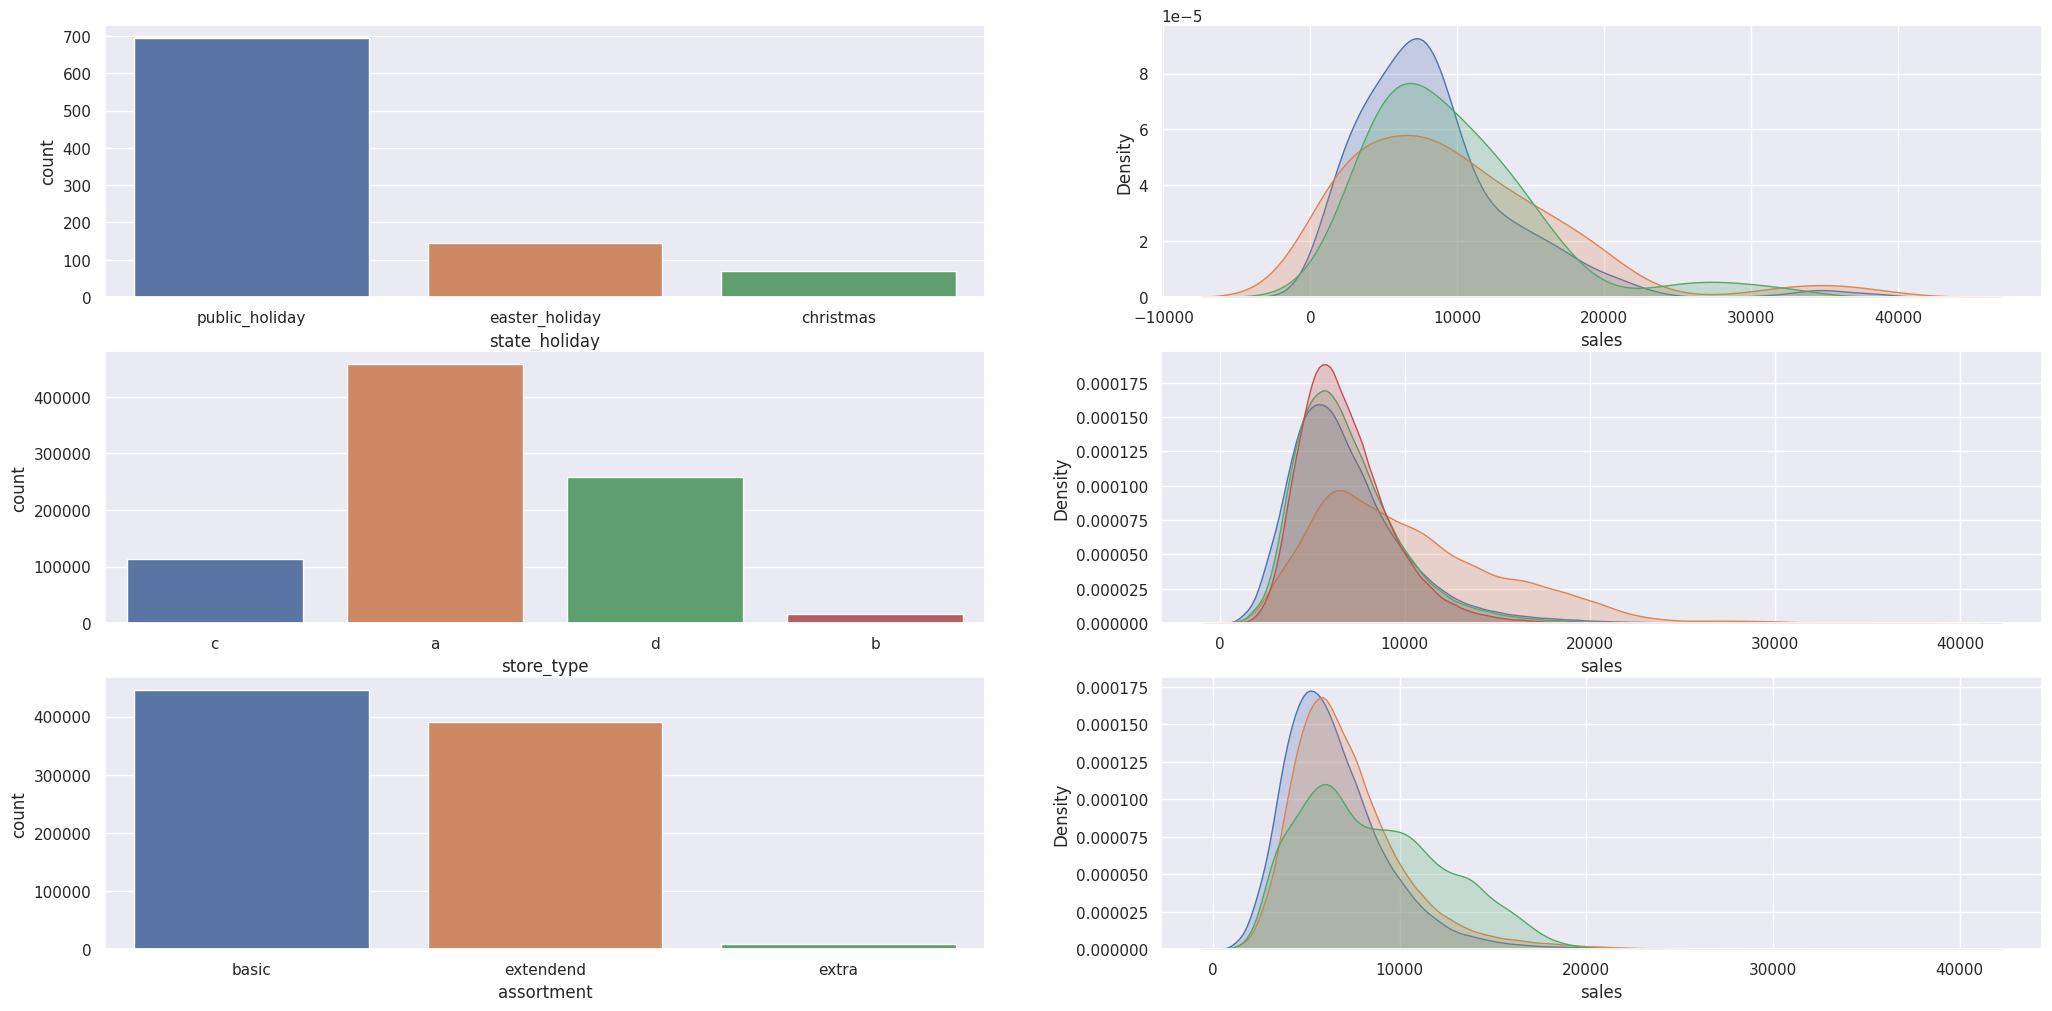

In [38]:
# state_holiday
plt.subplot ( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x='state_holiday', data=a, hue='state_holiday' );

plt.subplot ( 3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True );
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True );
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True );

# store_type
plt.subplot ( 3, 2, 3)
sns.countplot( x='store_type', data=df4, hue='store_type' );

plt.subplot ( 3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True );
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True );
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True );
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True );

#assortment
plt.subplot ( 3, 2, 5)
sns.countplot( x='assortment', data=df4, hue='assortment' );

plt.subplot ( 3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True );
sns.kdeplot(df4[df4['assortment'] == 'extendend']['sales'], label='extendend', fill=True );
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True );



   ## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

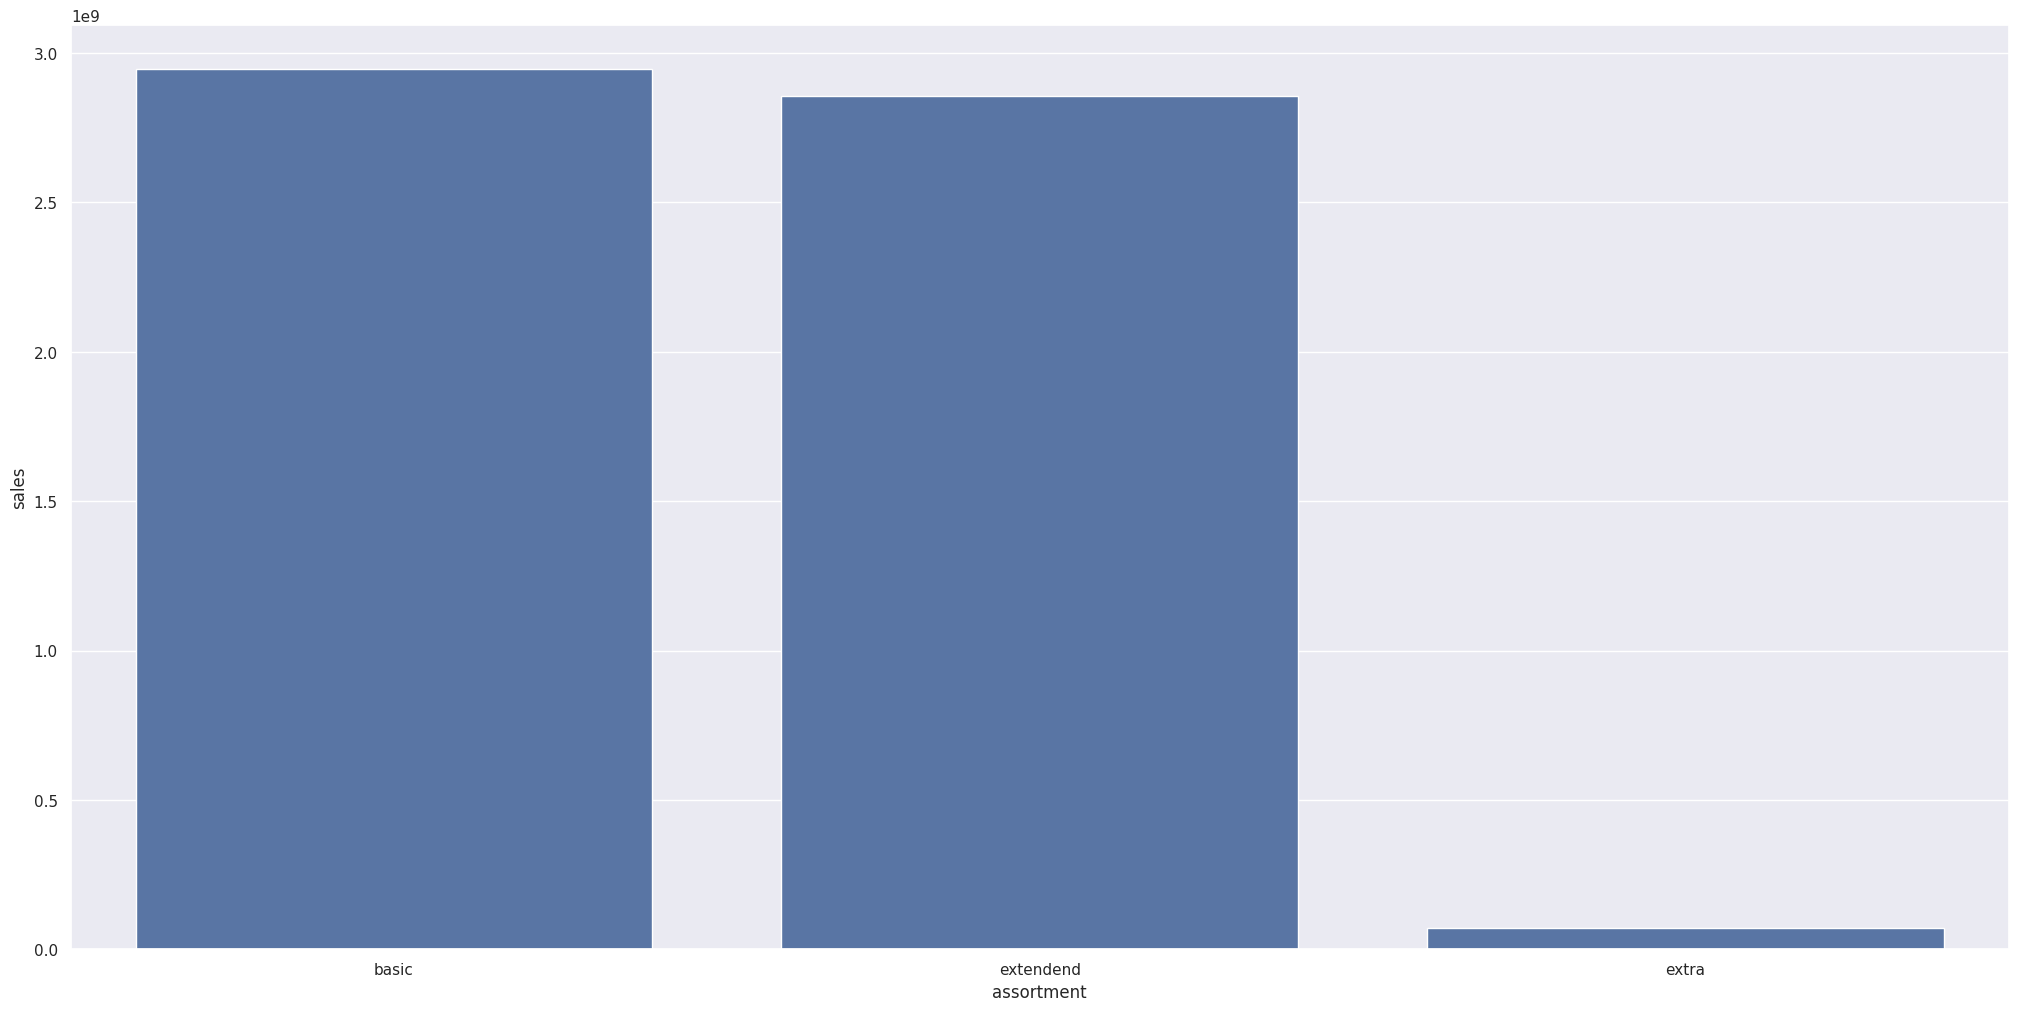

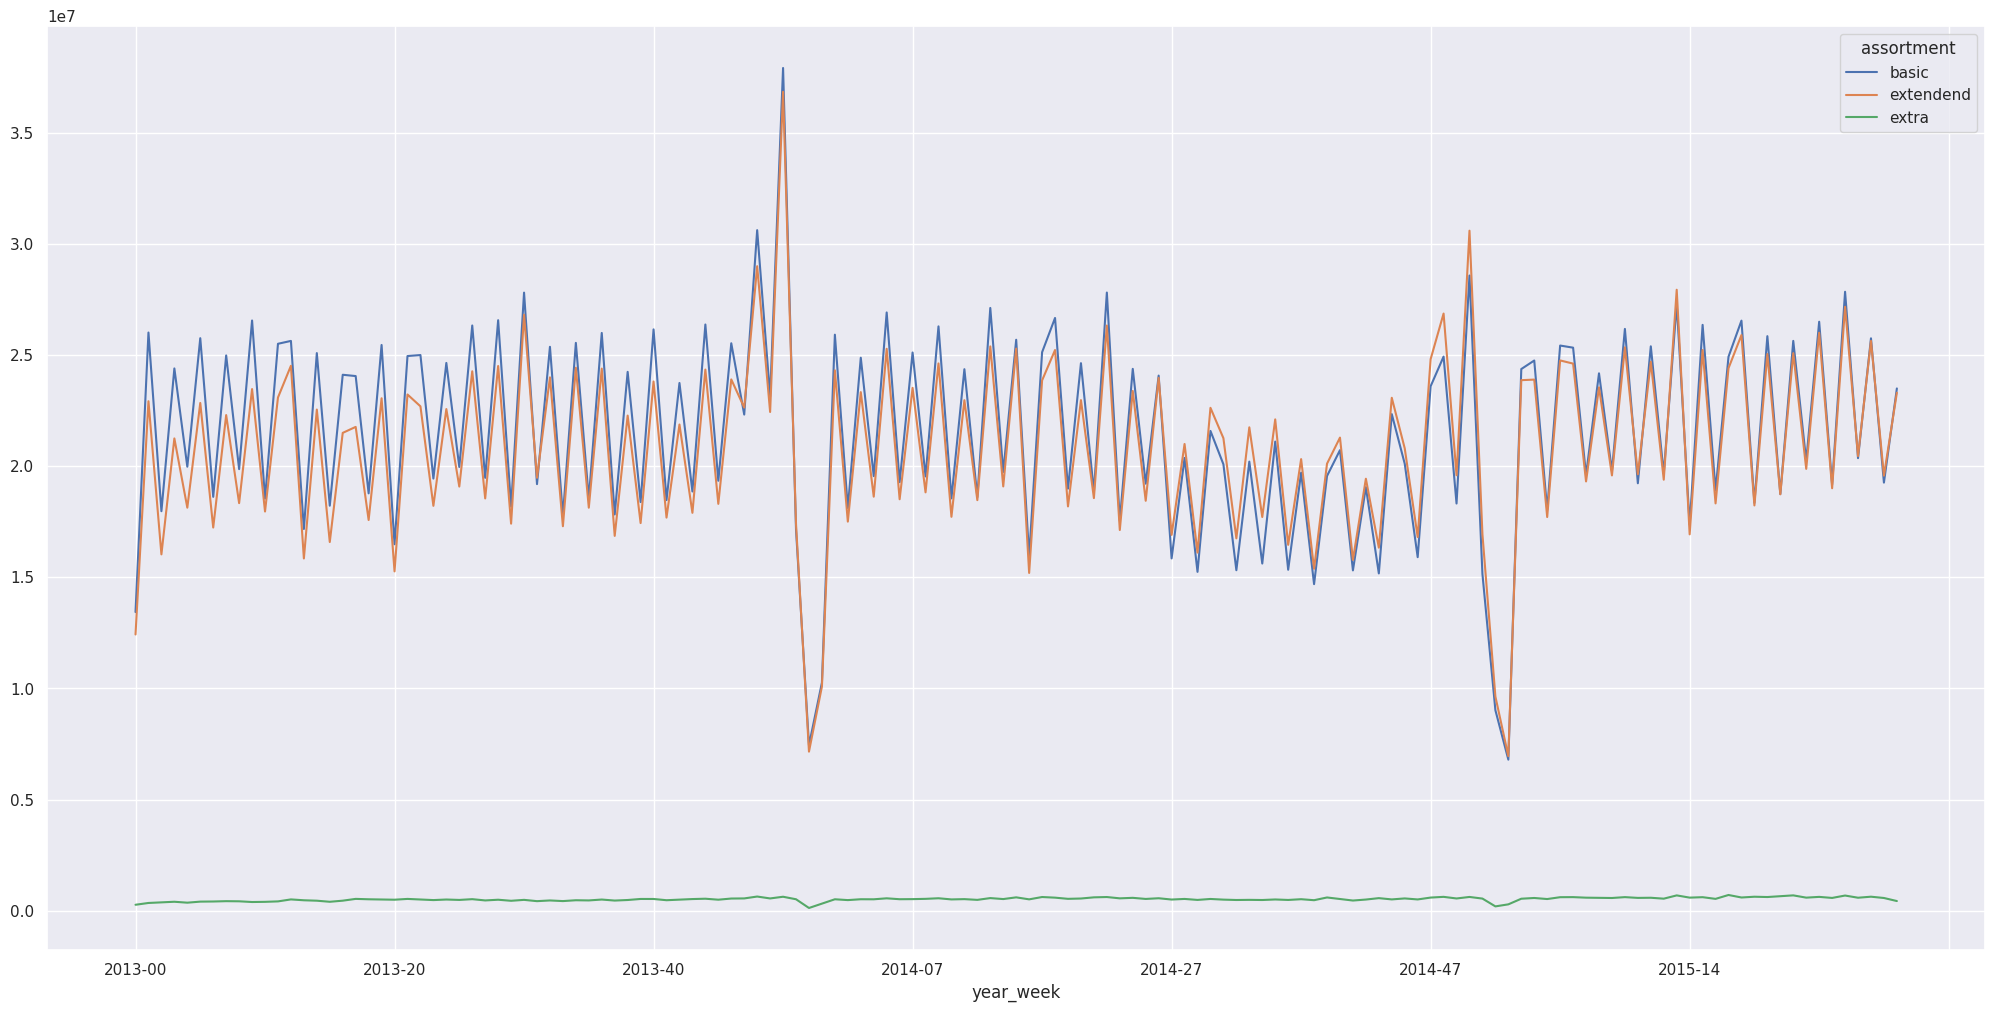

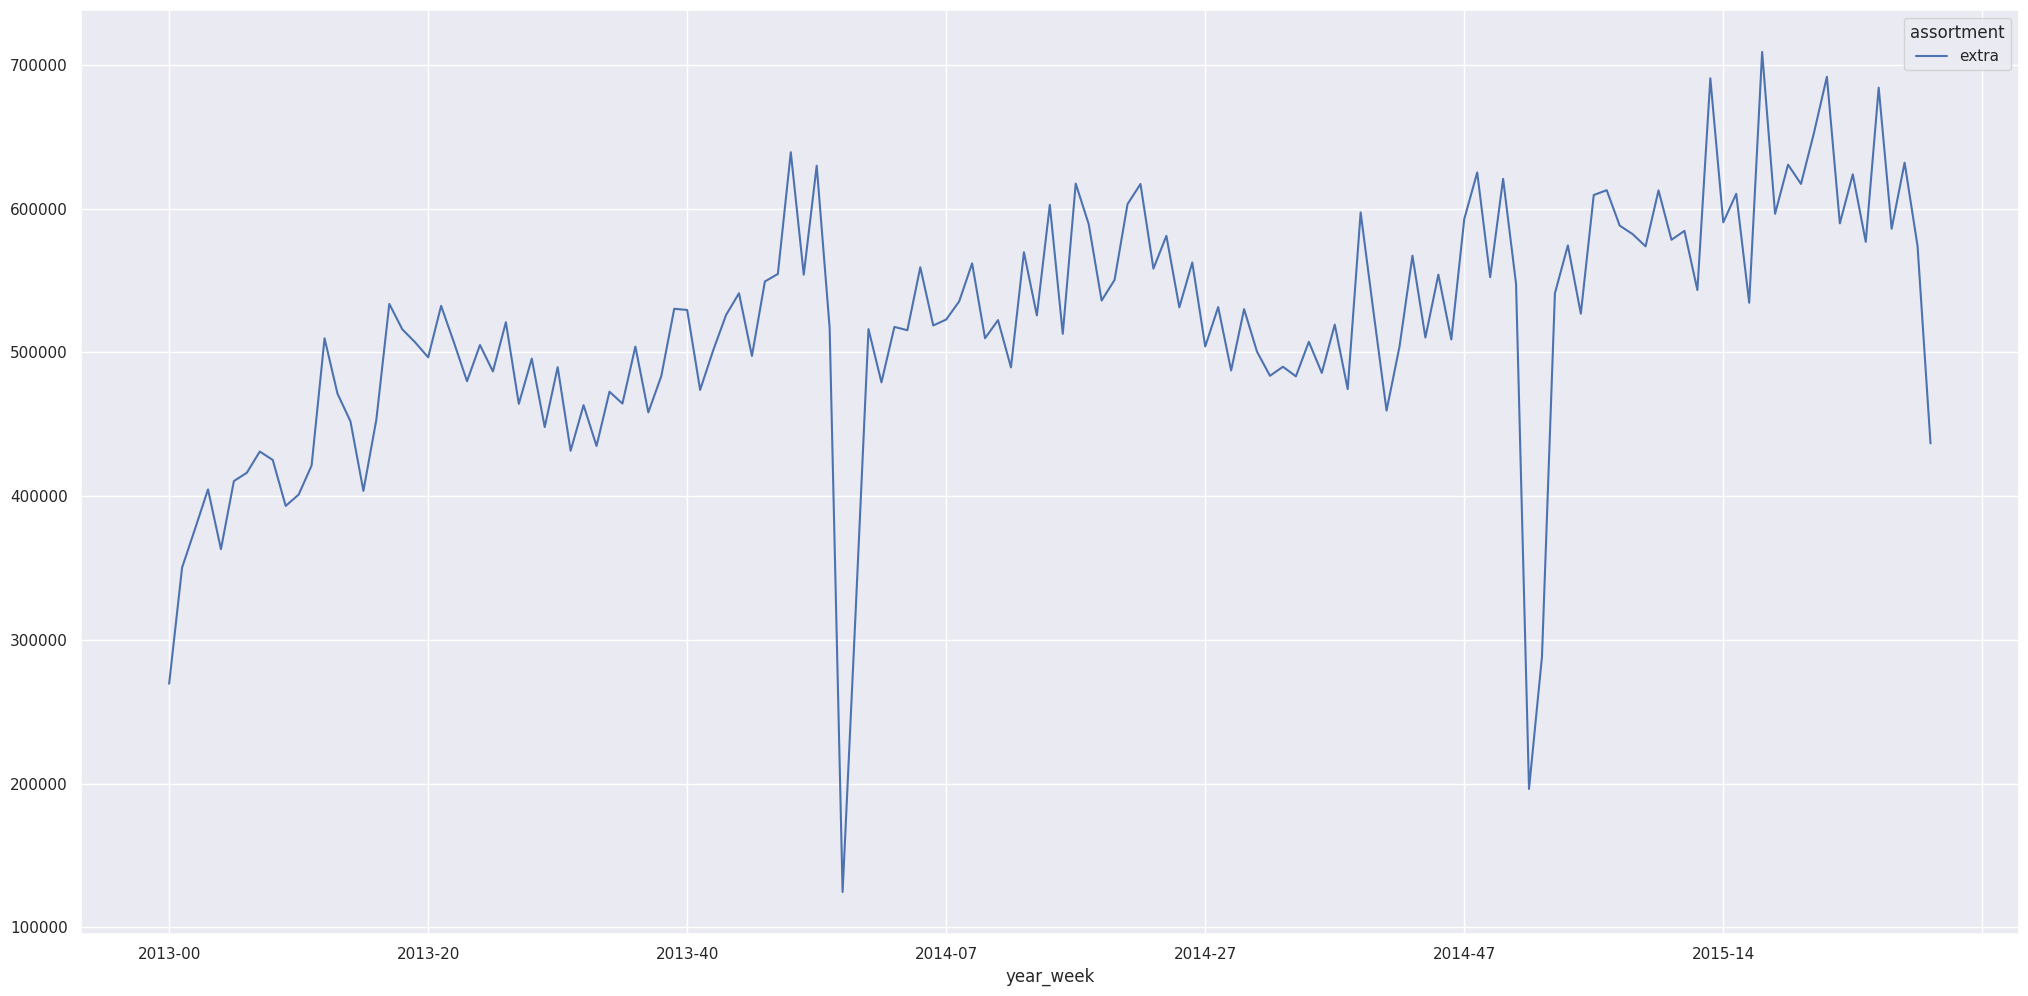

In [39]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();


aux3 = aux2[aux2['assortment'] =='extra' ]
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### **H2.** Lojas com competidores mais próximos devereiam vender menos.
**FALSA** Lojas com competidores mais próximos vendem mais.

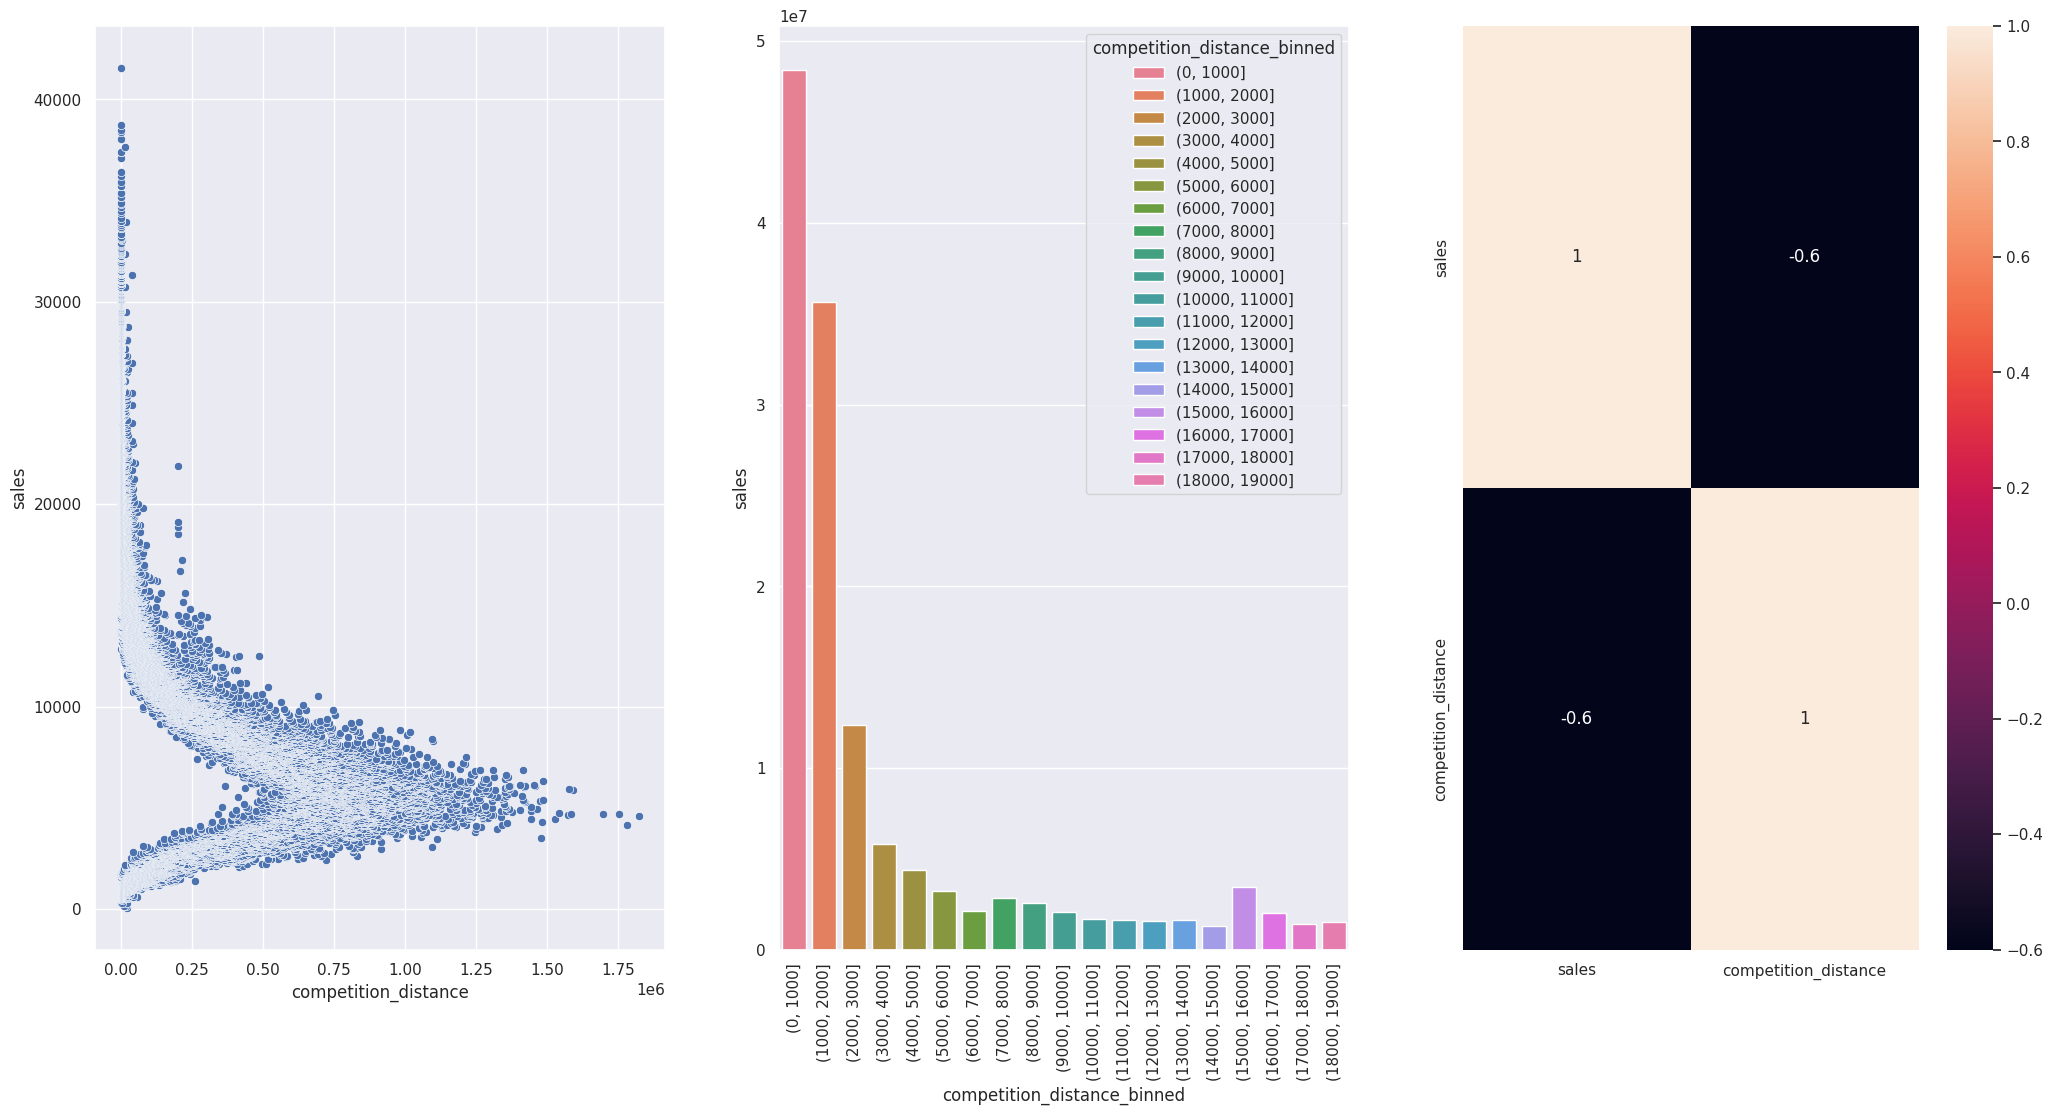

In [40]:
plt.subplot ( 1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby( 'sales' ).sum().reset_index()
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot ( 1, 3, 2)
aux1 = df4[['competition_distance', 'sales']].groupby( 'sales' ).sum().reset_index()
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( aux2, x='competition_distance_binned', y='sales', hue='competition_distance_binned' );
plt.xticks(rotation=90);

plt.subplot ( 1, 3, 3)
aux1 = df4[['competition_distance', 'sales']].groupby( 'sales' ).sum().reset_index().astype( int )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H3.** Lojas com competidores a mais tempo devereiam vender mais.
**FALSA** Lojas com COMPETIDORES a MAIS TEMPO VENDEM MENOS

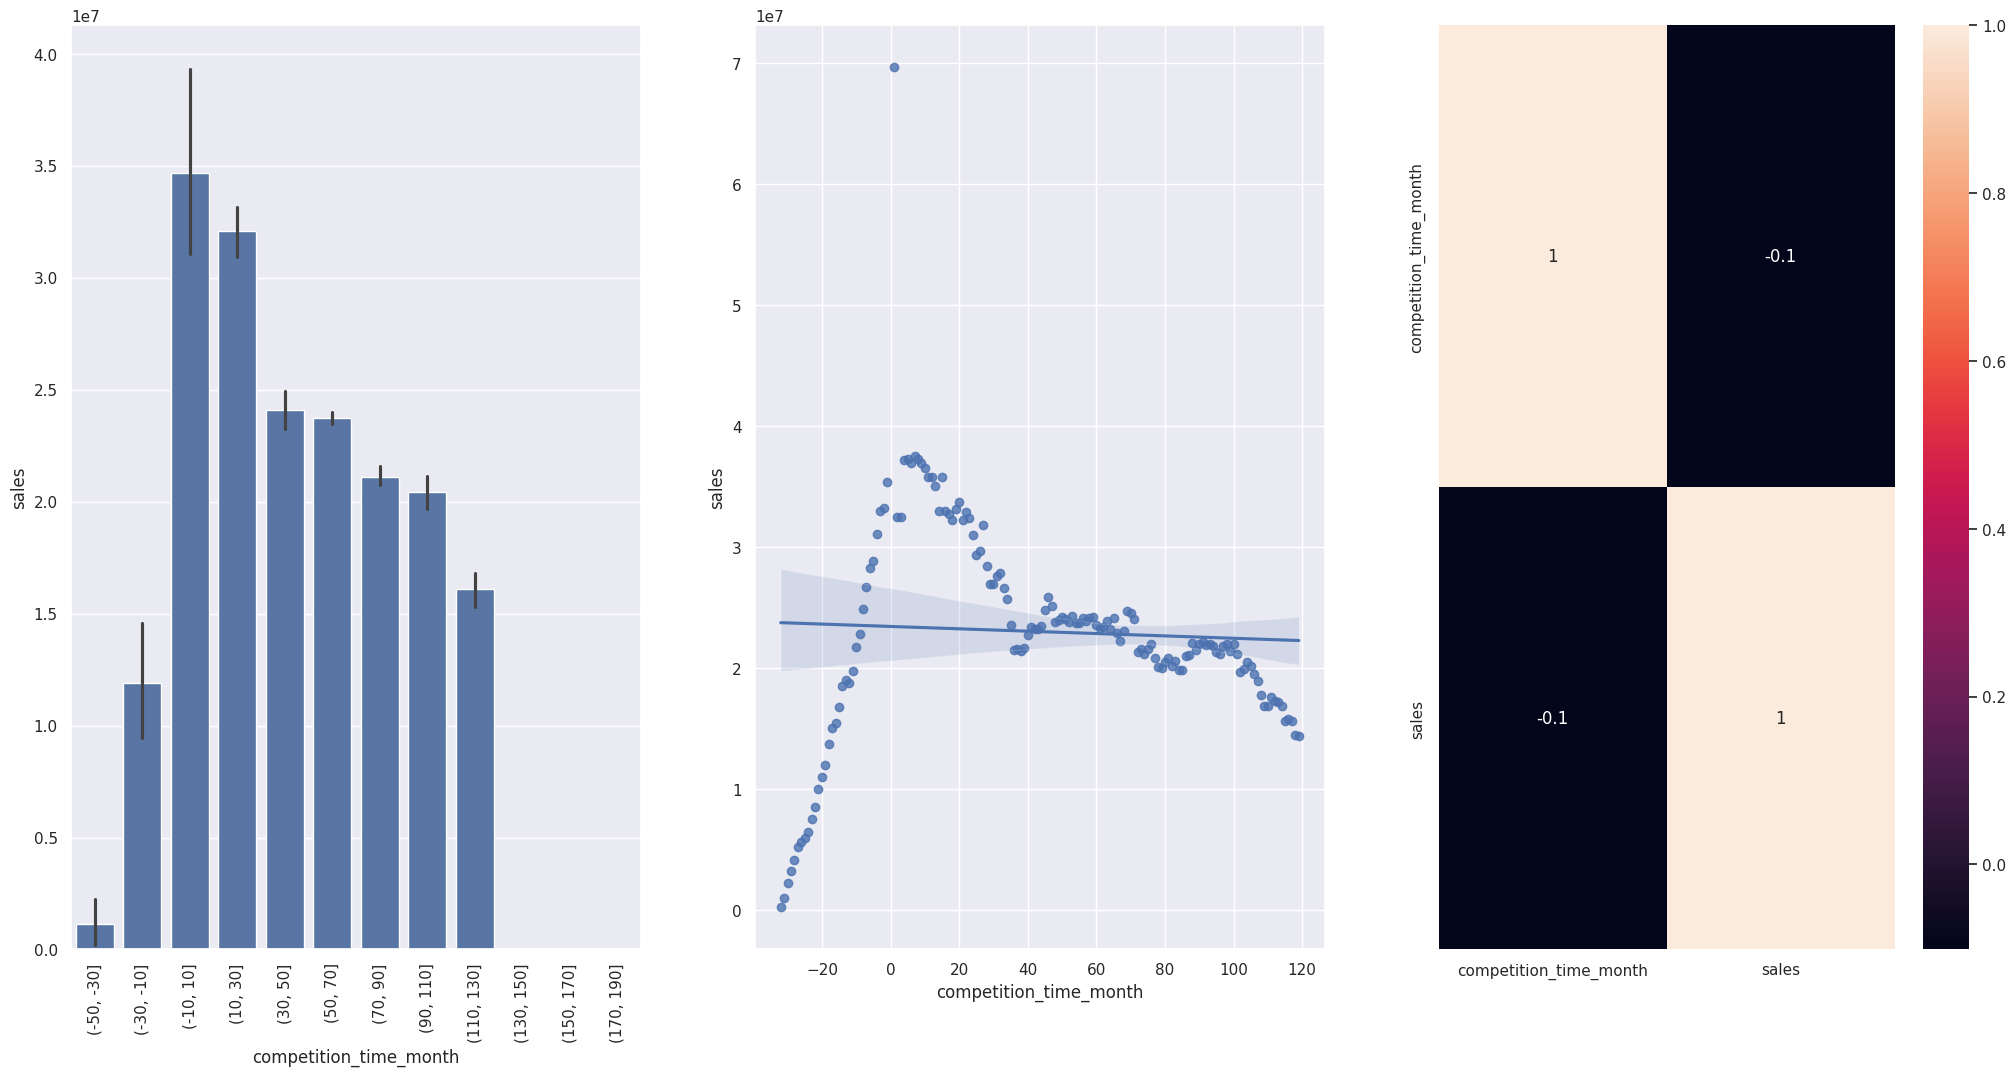

In [49]:
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'competition_time_month', 'sales' ]].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 ) ]
bins = list( np.arange( -50, 200, 20 ) )
categories = pd.cut(aux2['competition_time_month'], bins=bins)
# Usar as categorias criadas no gráfico de barras
sns.barplot(x=categories, y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot( 1, 3, 2 )
aux1 = df4[[ 'competition_time_month', 'sales' ]].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 ) ]
sns.regplot( aux2, x='competition_time_month', y='sales' );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
***FALSA***. Lojas com promoções ativas vendem menos após certo período de promoção.

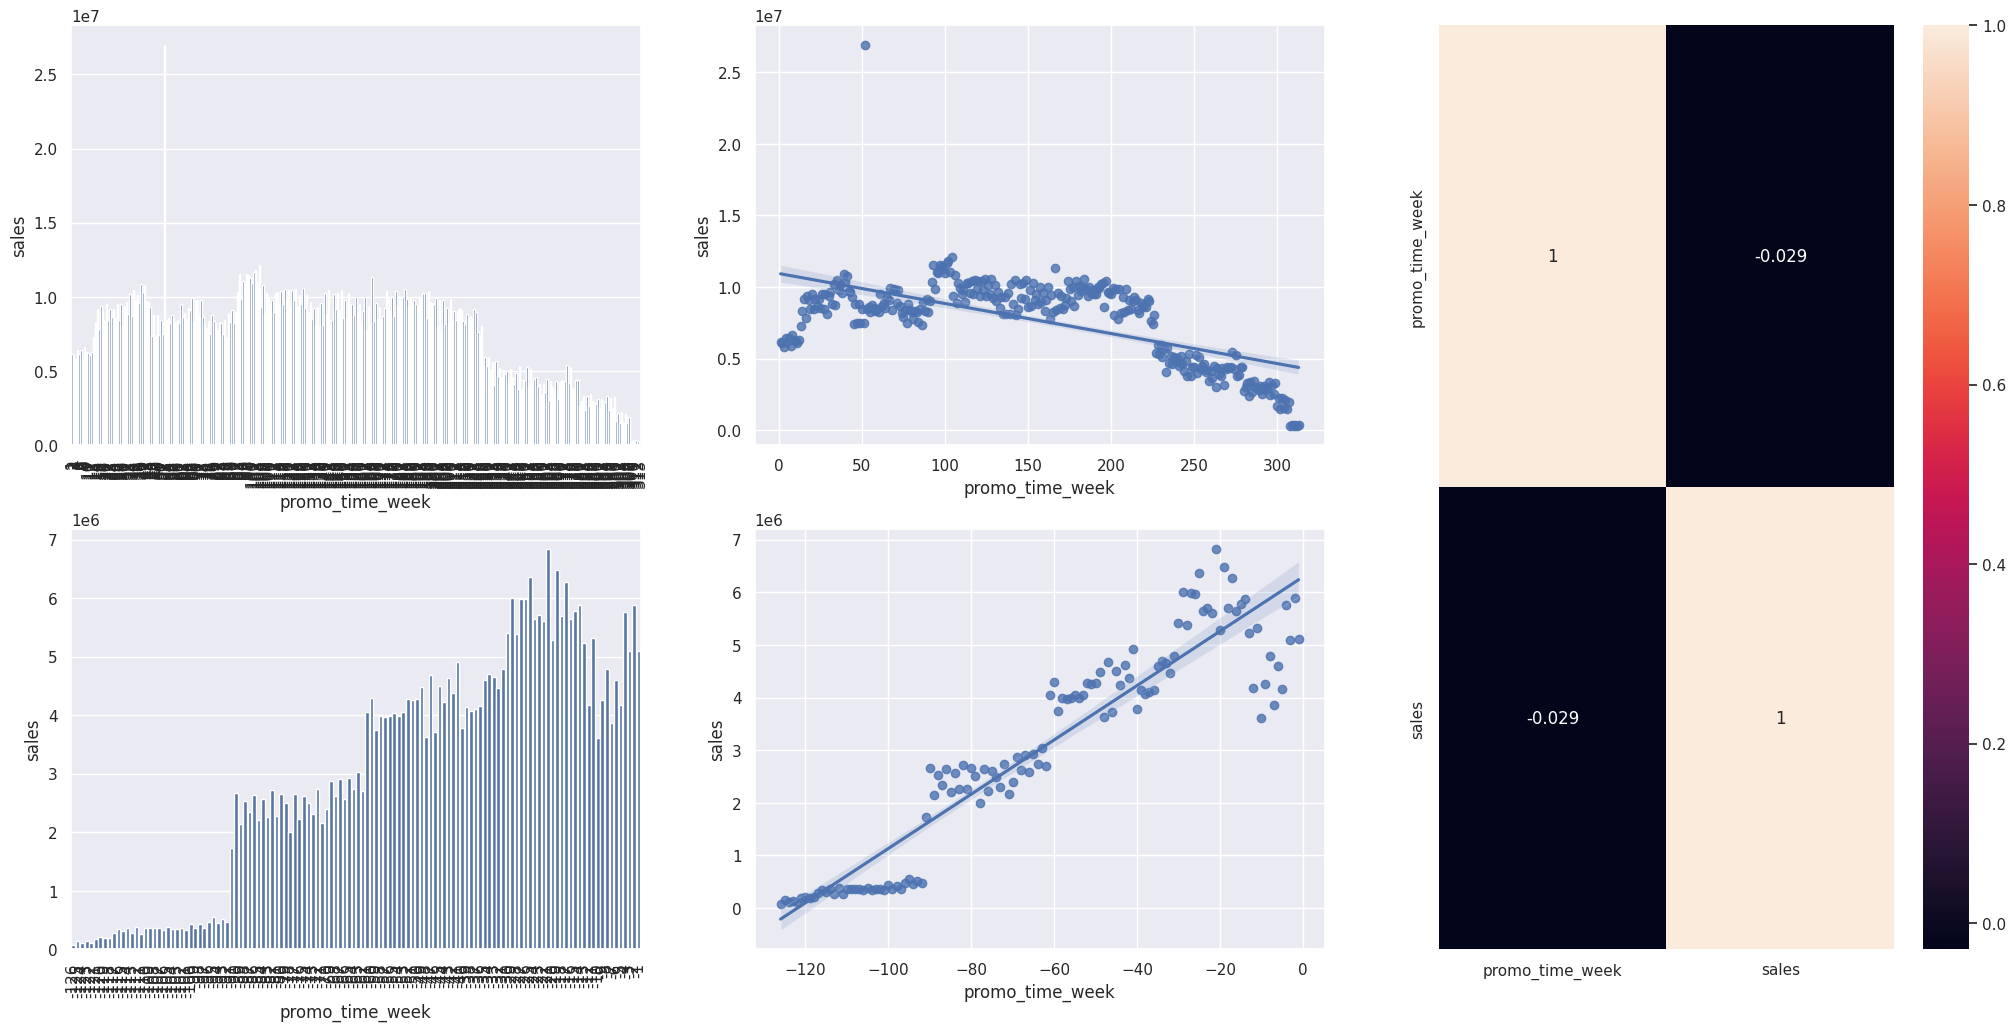

In [50]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot( data=aux2, x='promo_time_week', y='sales' );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( data=aux2, x='promo_time_week', y='sales' );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( data=aux3, x='promo_time_week', y='sales' );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( data=aux3, x='promo_time_week', y='sales' );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções censecutivas deveriam vender mais.
***FALSA*** Lojas com mais promoções consecutivas vendem menos.

In [51]:
aux1 = df4[[ 'promo', 'promo2', 'sales' ]].groupby(['promo', 'promo2'] ).sum().reset_index().sort_values(by='sales', ascending=True)
#sns.barplot( data=aux1, x=('promo', 'promo2'), y='sales' );
aux1

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


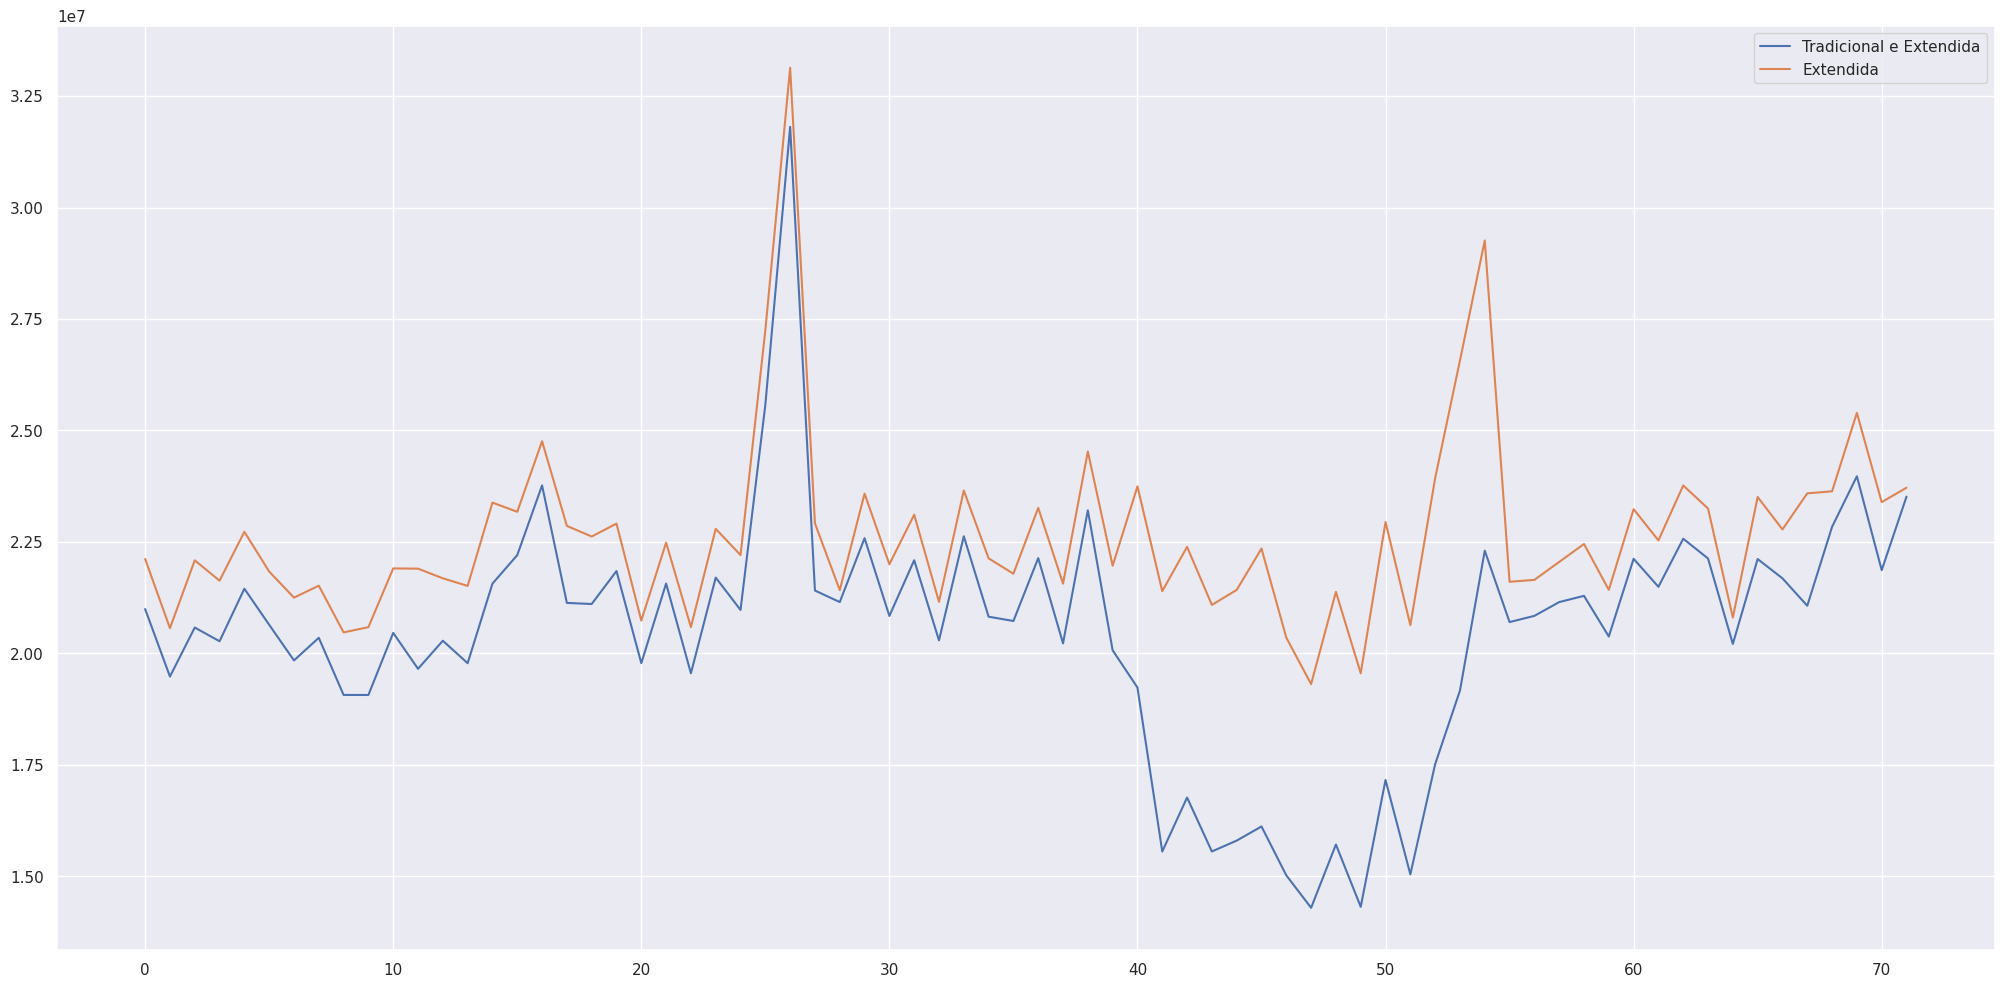

In [52]:
aux1 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional e Extendida', 'Extendida'] );

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais.
***FALSA*** As lojas vendem MAIS nos demais Feriados.

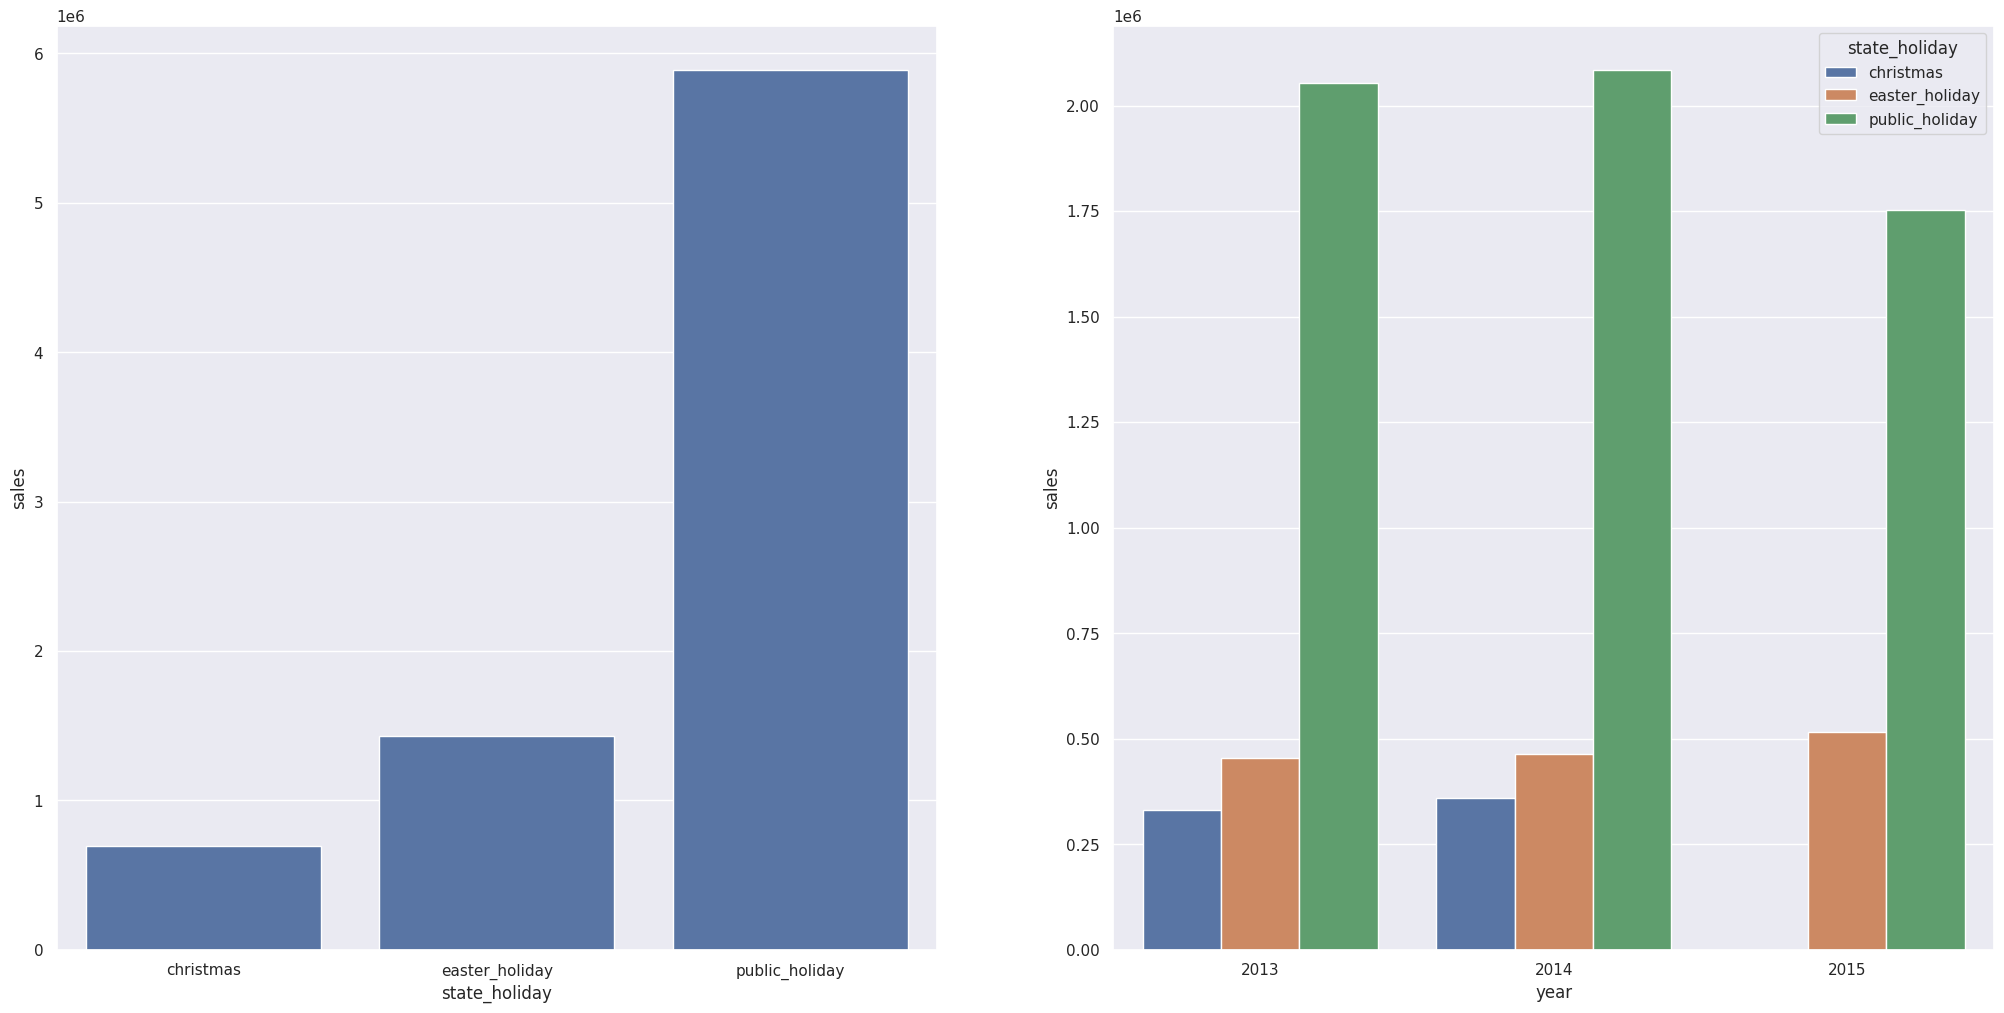

In [53]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot ( 1, 2, 1 )
sns.barplot( data=aux1, x='state_holiday', y='sales' );

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.subplot ( 1, 2, 2 )
sns.barplot( data=aux2, x='year', y='sales', hue='state_holiday' );

### **H8.** Lojas deveriam vender mais ao longo dos anos.
***FALSA*** Lojas vendem menos ao longo dos anos.

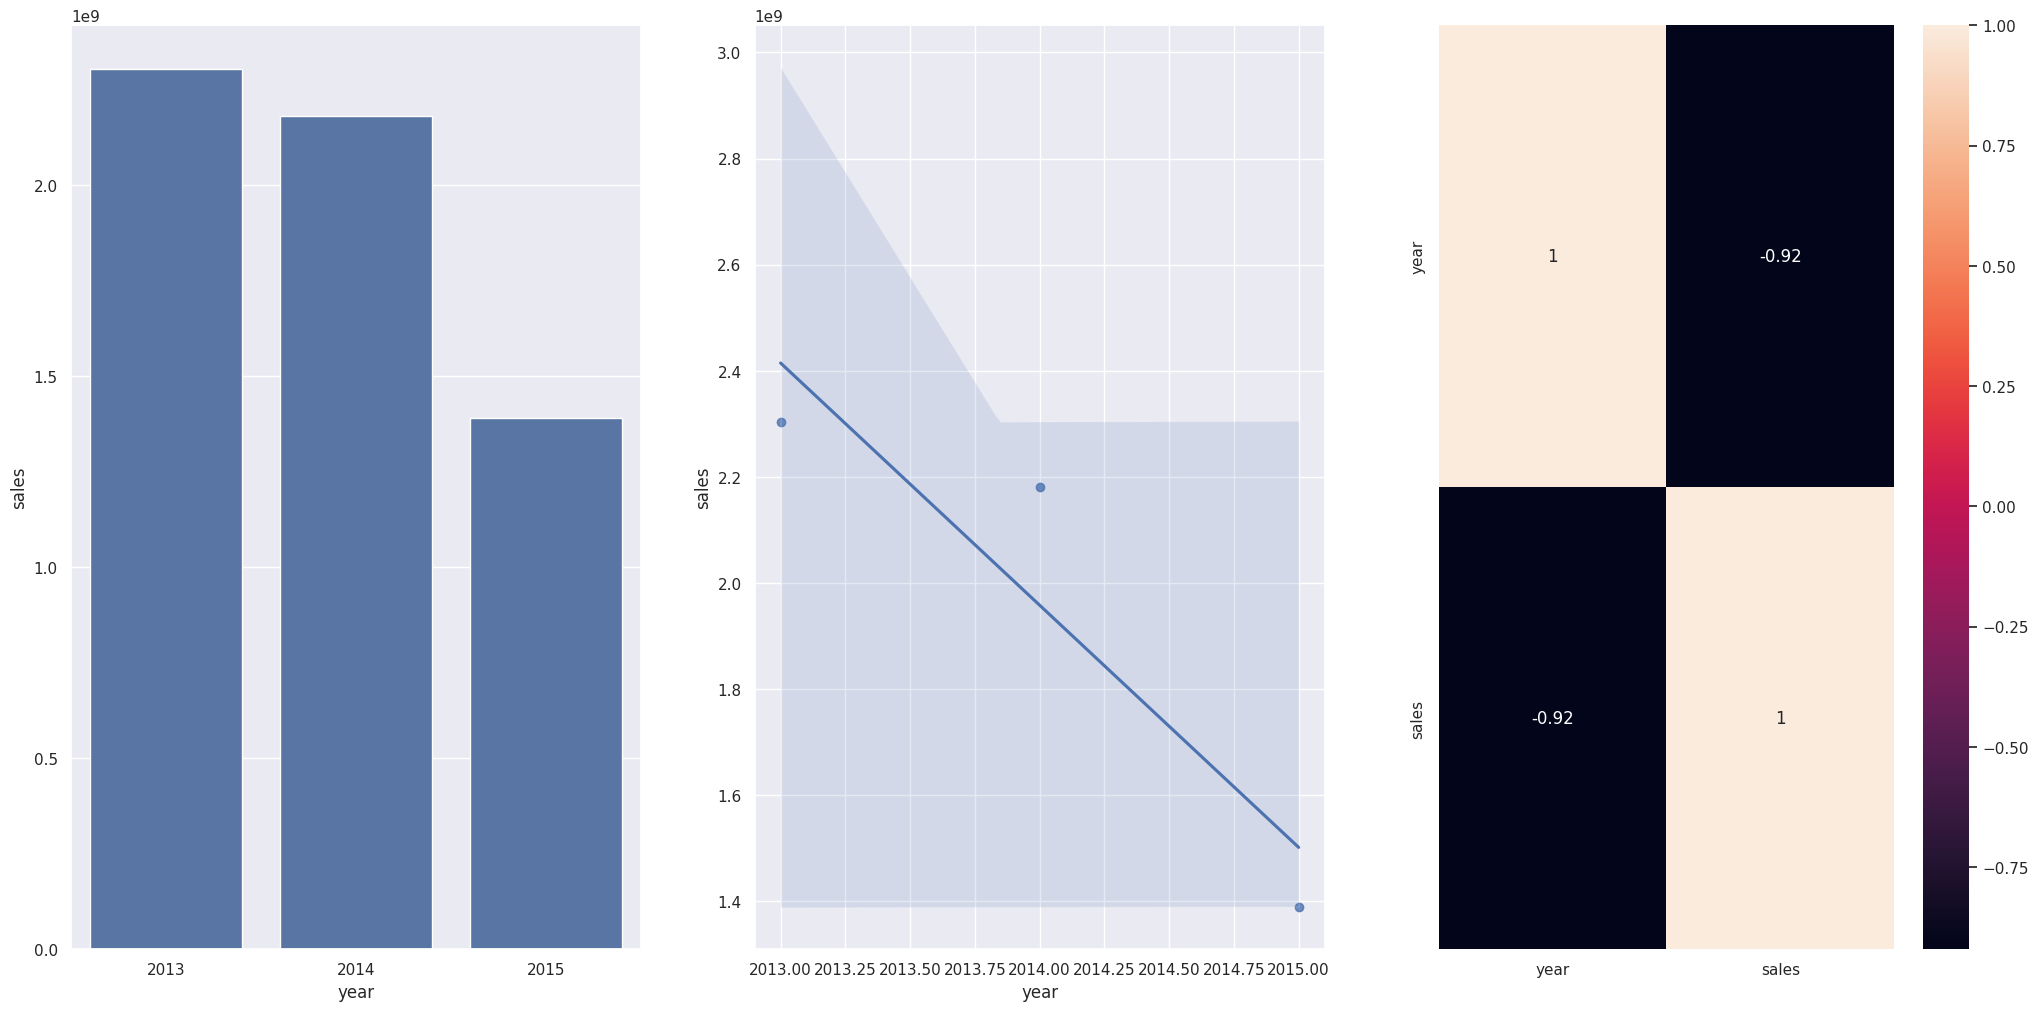

In [54]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot( 1, 3, 1)
sns.barplot( data=aux1, x='year', y='sales' );

plt.subplot( 1, 3, 2)
sns.regplot( data=aux1, x='year', y='sales' );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
***FALSA*** As lojas vendem mais no primeiro semestre.



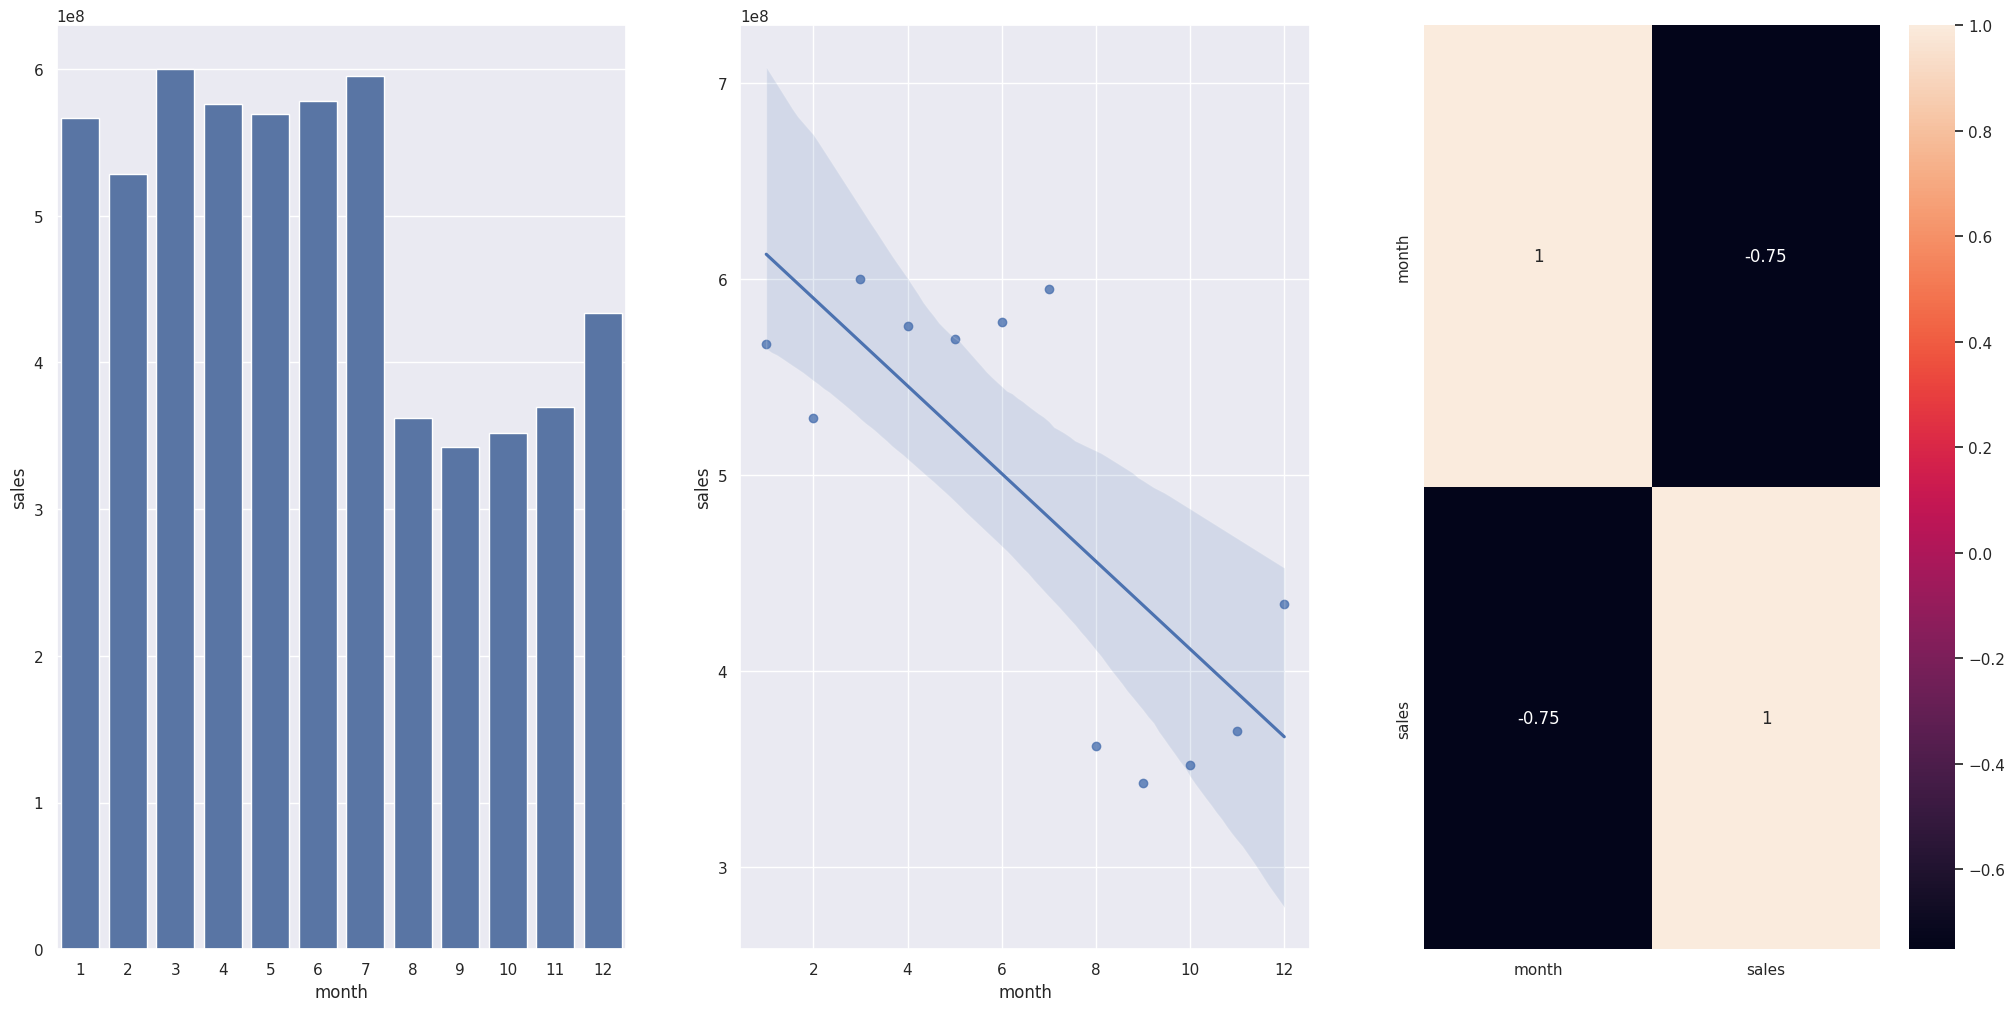

In [55]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot( 1, 3, 1)
sns.barplot( data=aux1, x='month', y='sales' );

plt.subplot( 1, 3, 2)
sns.regplot( data=aux1, x='month', y='sales' );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
***VERDADEIRA*** Lojas vendem menos até o dia 10.


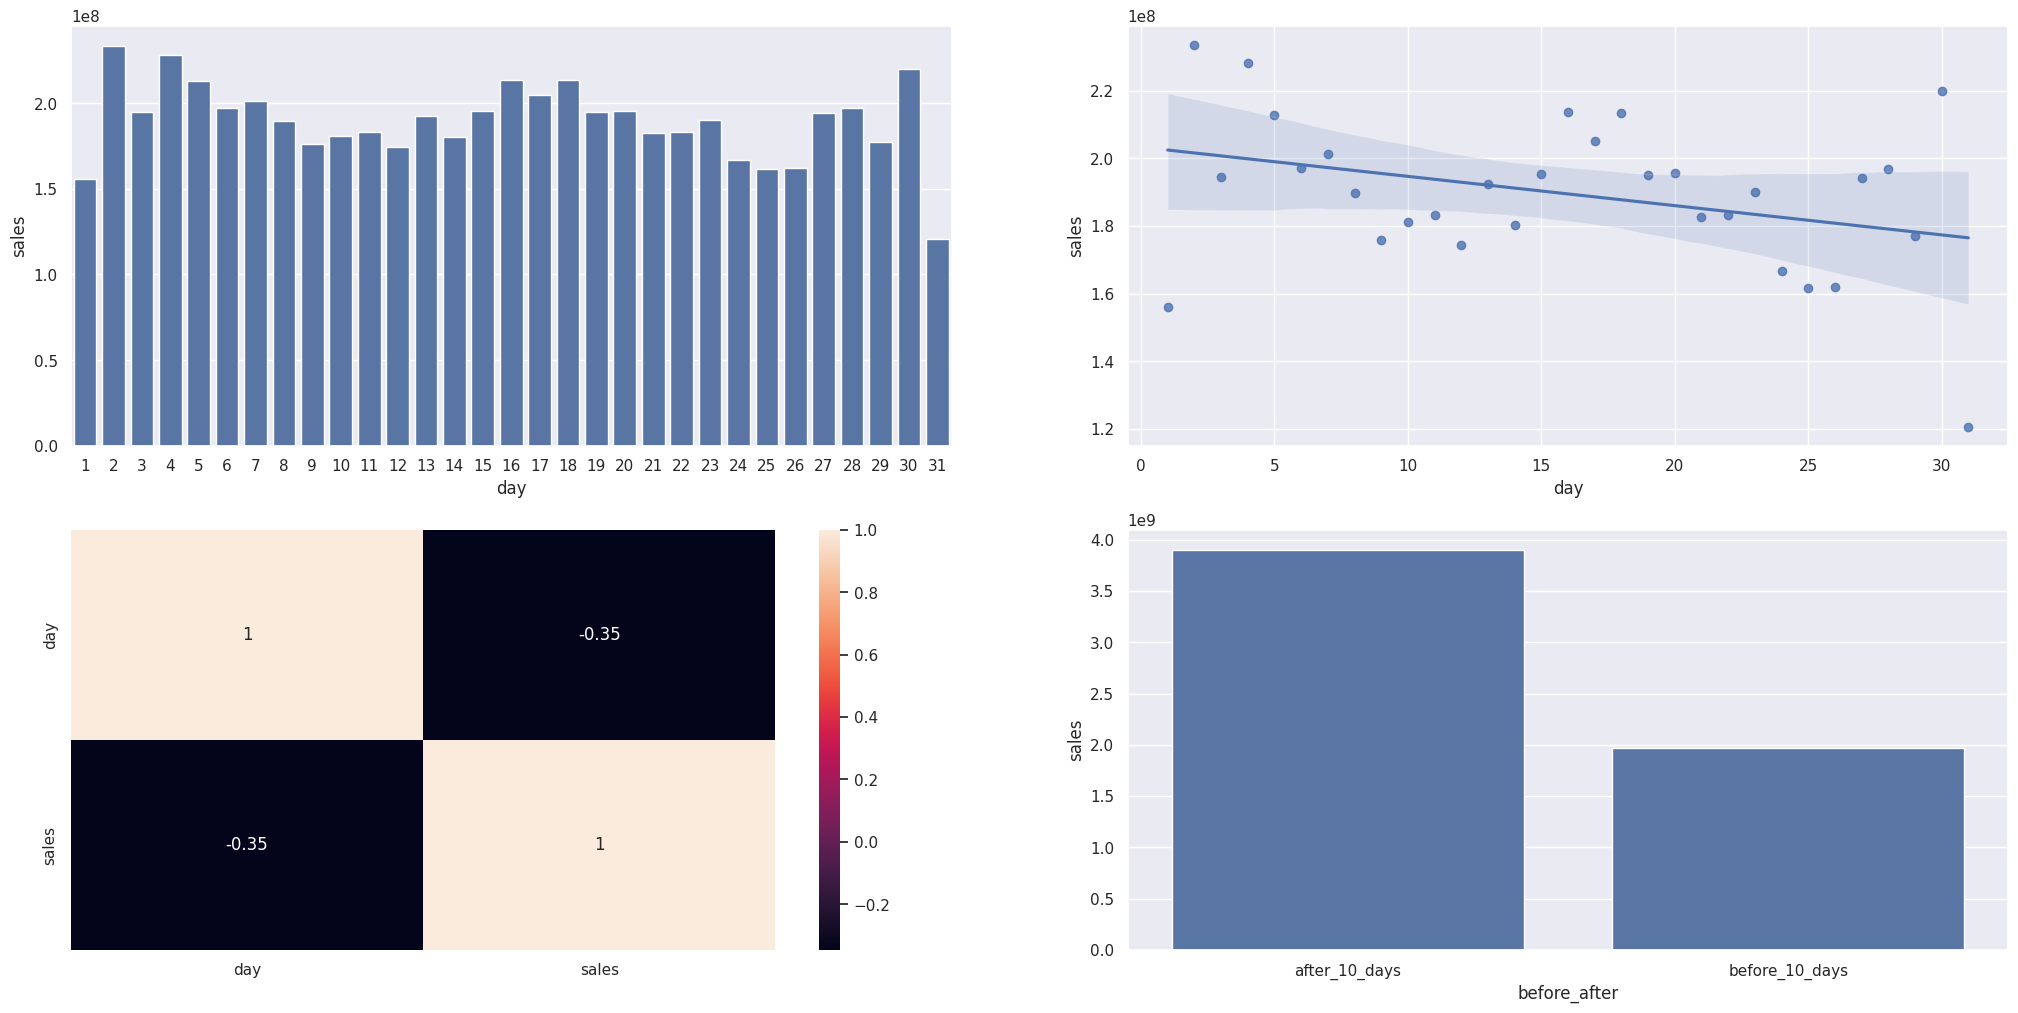

In [56]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot( 2, 2, 1)
sns.barplot( data=aux1, x='day', y='sales' );

plt.subplot( 2, 2, 2)
sns.regplot( data=aux1, x='day', y='sales' );

plt.subplot( 2, 2, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2, 2, 4)
sns.barplot ( data=aux2, x='before_after', y='sales' );

### **H11.** Lojas deveriam vender menos aos finais de semana.
***VERDADEIRA*** Lojas vendem mais nos dias regulares.



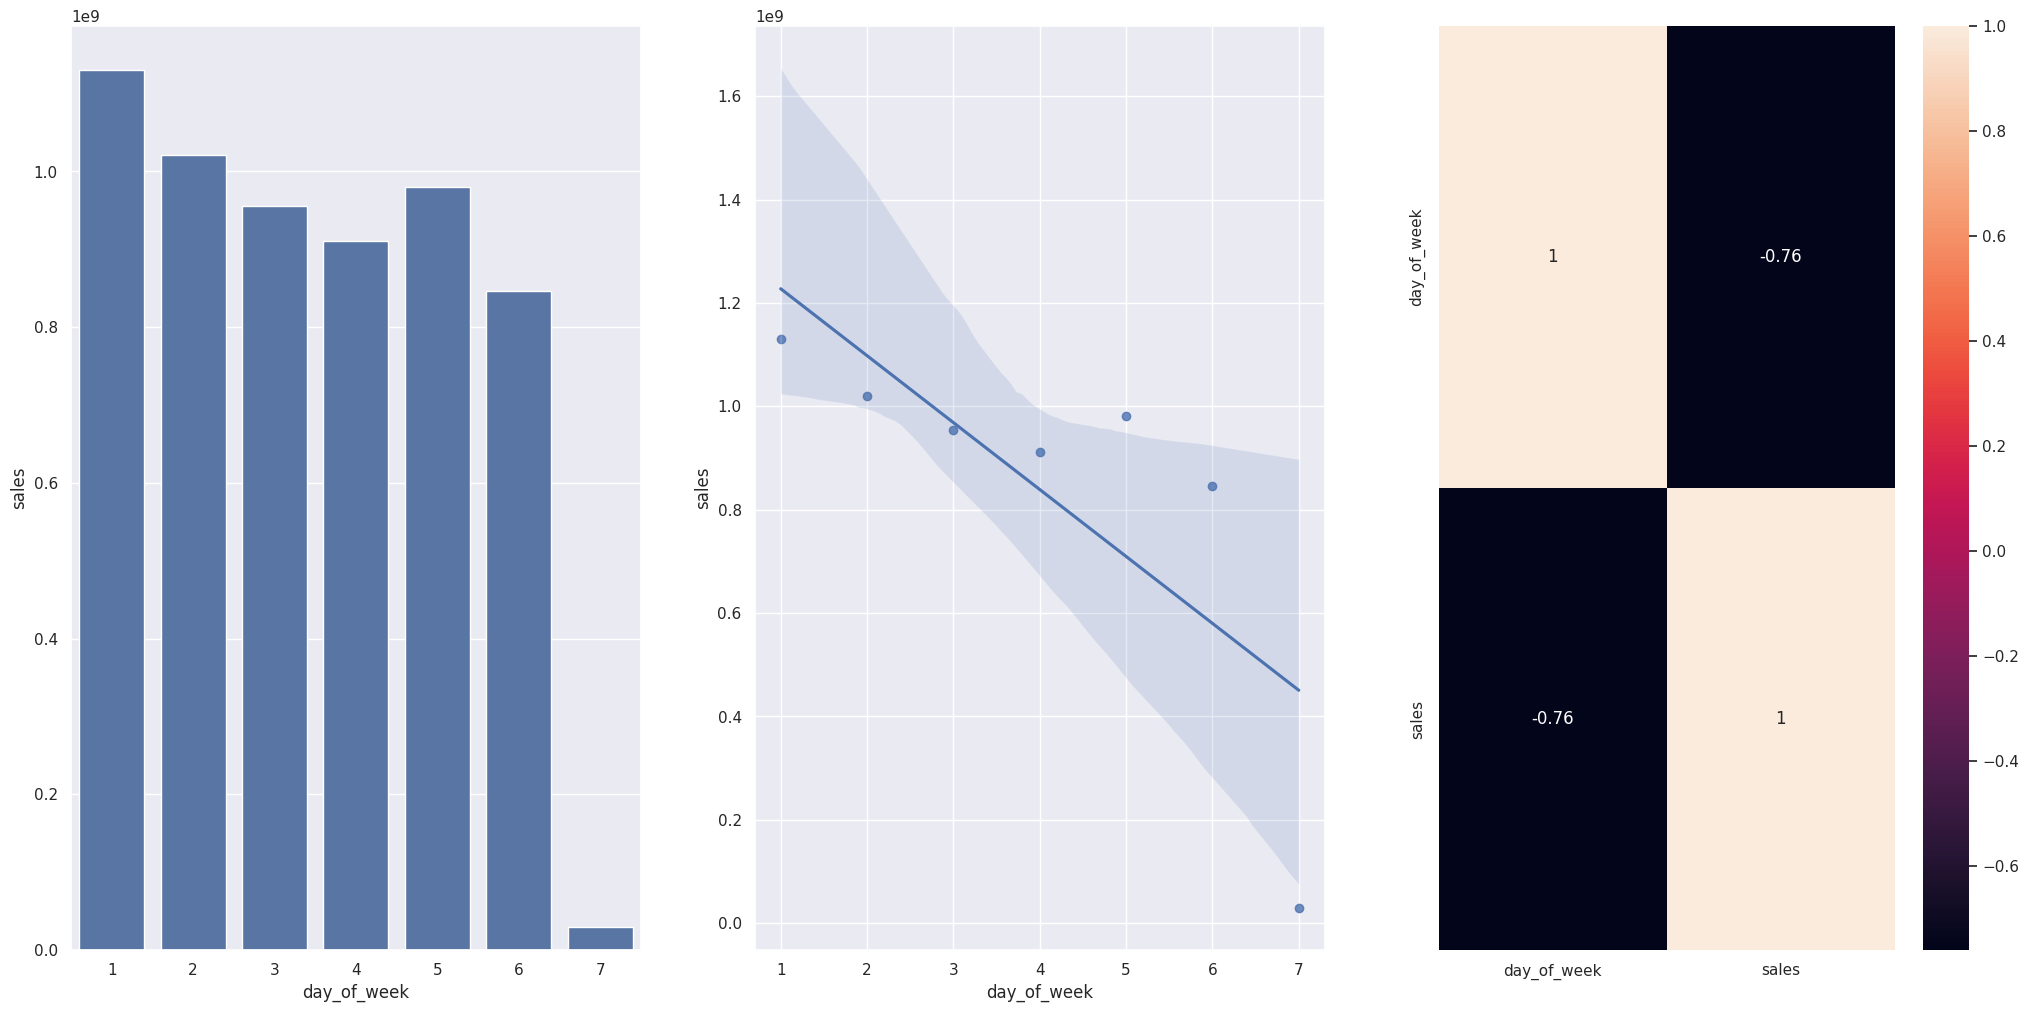

In [57]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.subplot( 1, 3, 1)
sns.barplot( data=aux1, x='day_of_week', y='sales' );

plt.subplot( 1, 3, 2)
sns.regplot( data=aux1, x='day_of_week', y='sales' );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
***VERDADEIRA*** Lojas vendem menos nos feriados escolares.

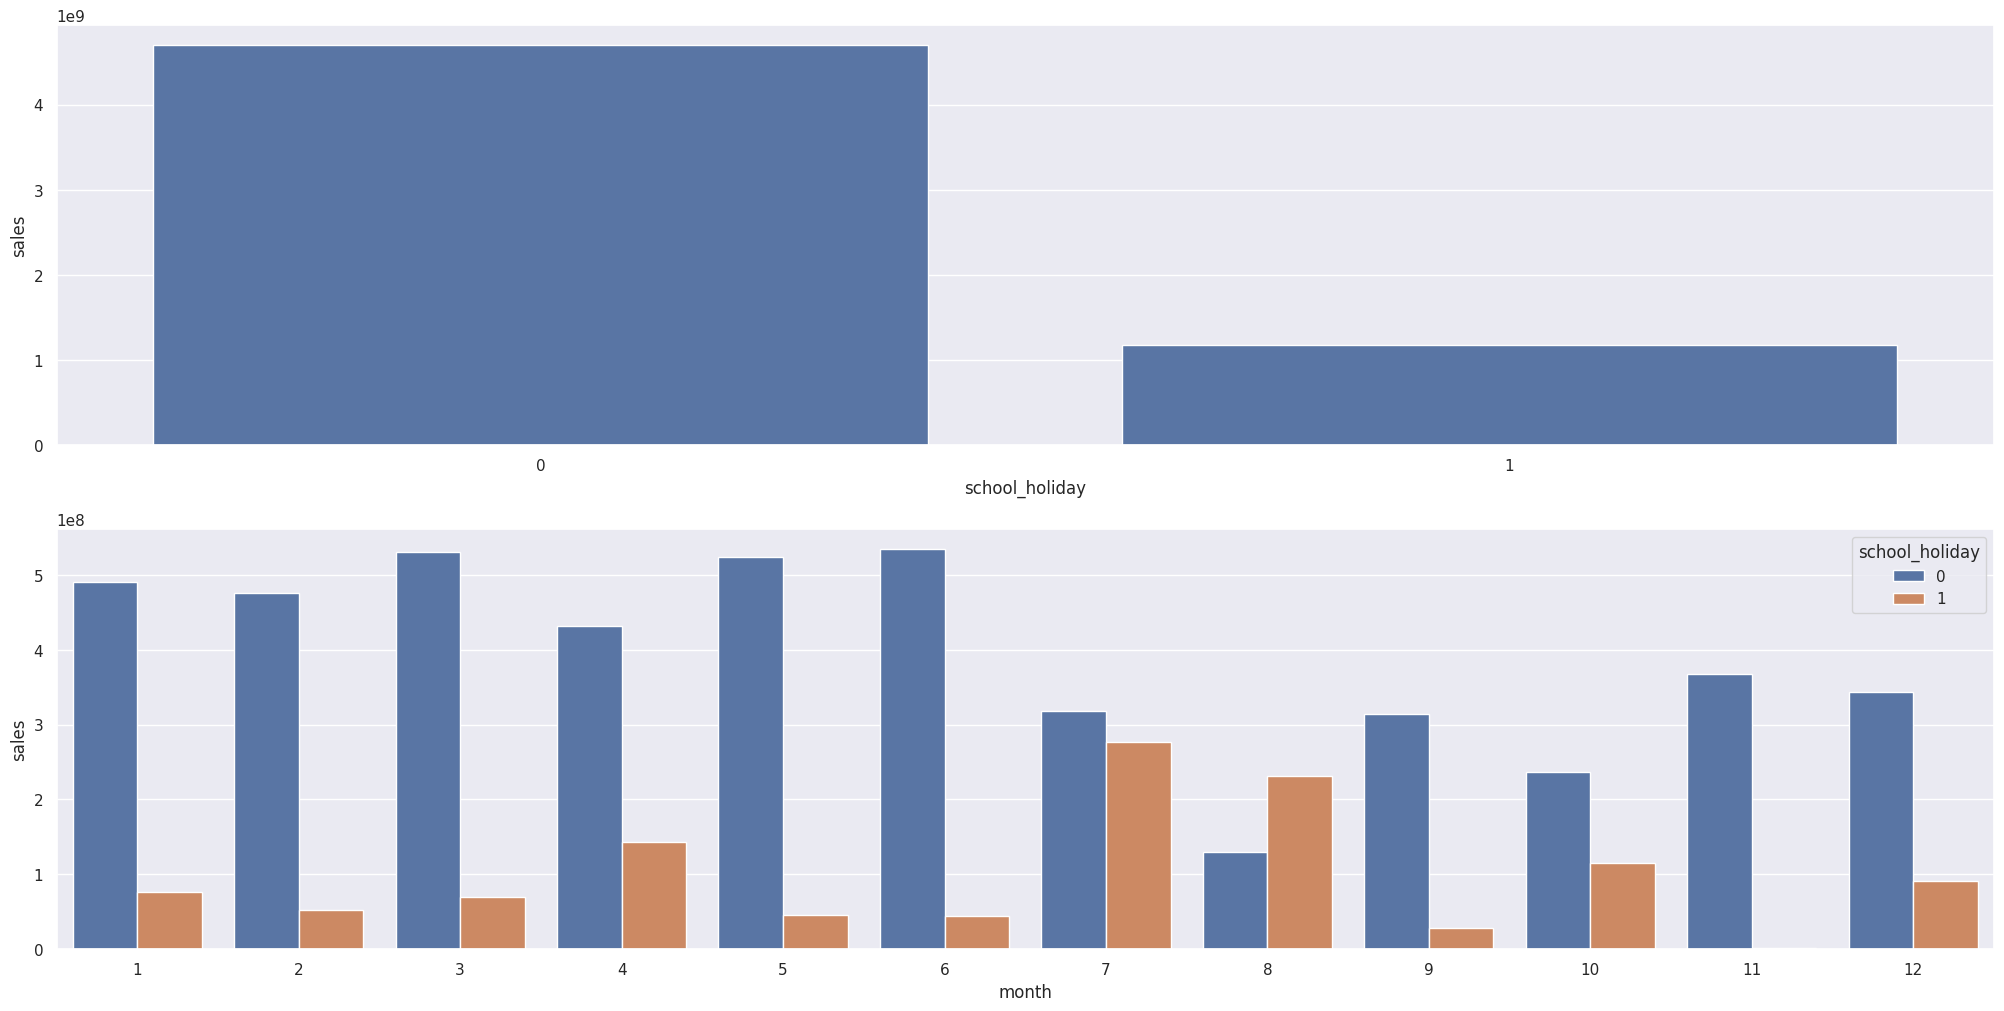

In [58]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot( 2, 1, 1)
sns.barplot( data=aux1, x='school_holiday', y='sales' );

aux2 = df4[[ 'month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot( 2, 1, 2)
sns.barplot( data=aux2, x='month', y='sales', hue='school_holiday' );

### 4.2.1 Resumo das hipóteses

In [59]:
tab= [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa']
      ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


  ## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

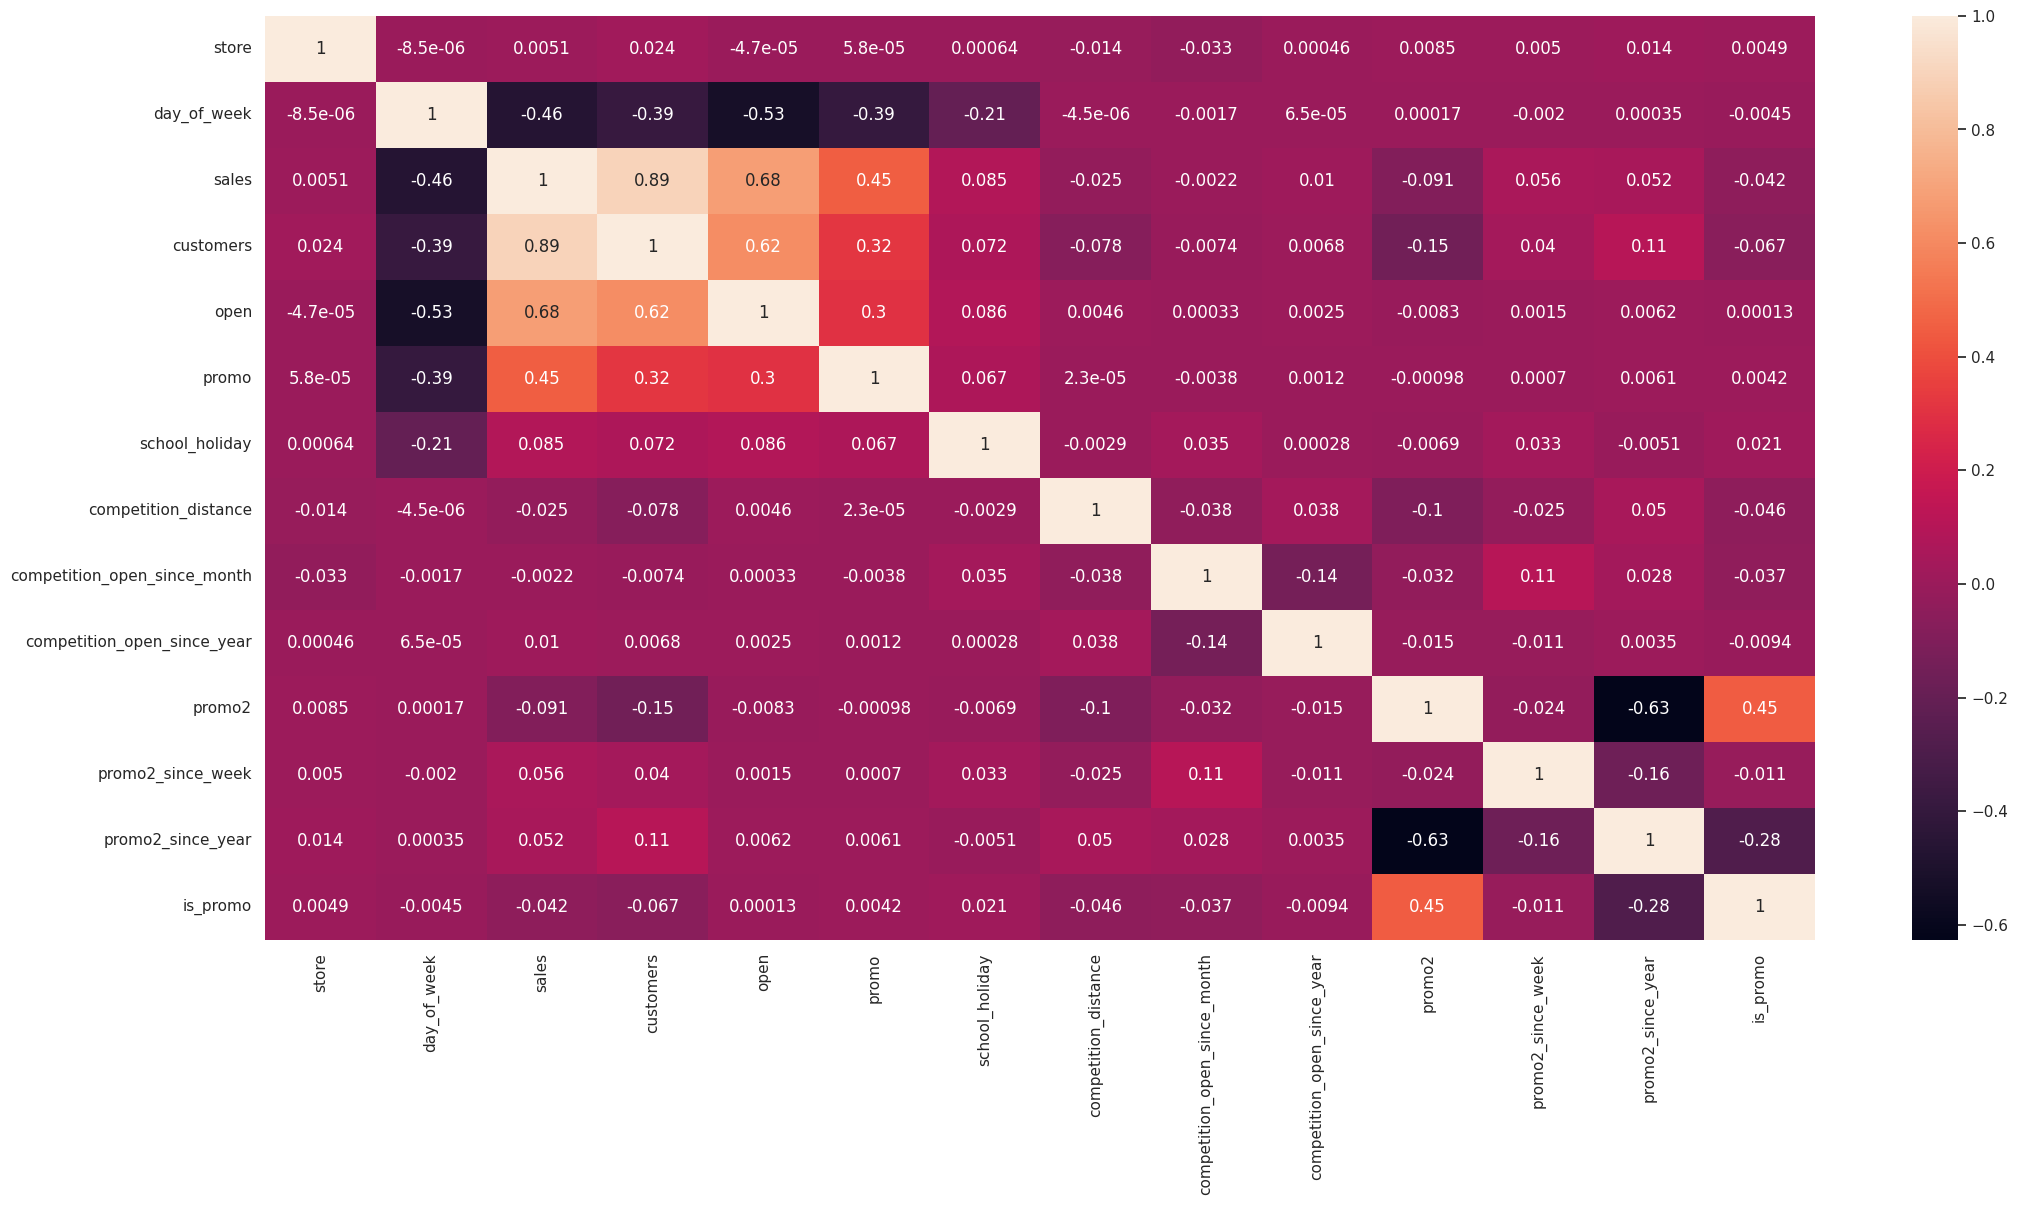

In [60]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

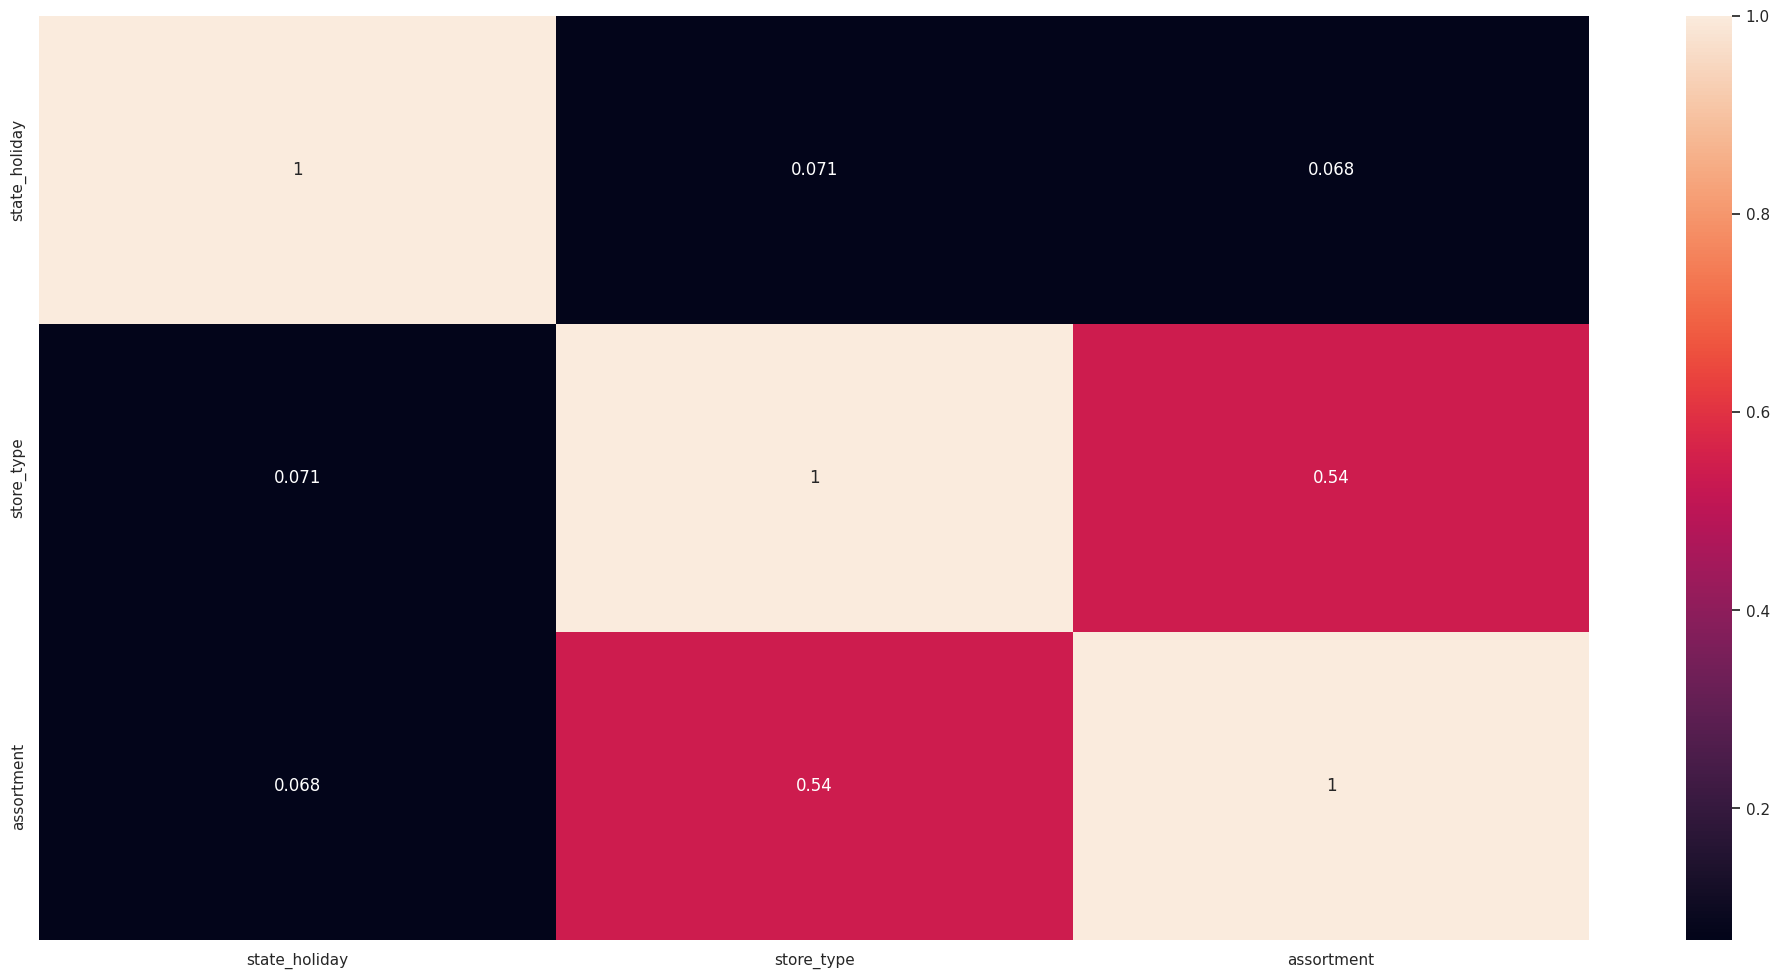

In [61]:
# Only categorical data
a = df4.select_dtypes( include='object' )

# Calculate Cramer V
a1 = cramer_v ( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v ( a['state_holiday'], a['store_type'] )
a3 = cramer_v ( a['state_holiday'], a['assortment'] )

a4 = cramer_v ( a['store_type'], a['state_holiday'] )
a5 = cramer_v ( a['store_type'], a['store_type'] )
a6 = cramer_v ( a['store_type'], a['assortment'] )

a7 = cramer_v ( a['assortment'], a['state_holiday'] )
a8 = cramer_v ( a['assortment'], a['store_type'] )
a9 = cramer_v ( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [ a1, a2, a3 ],
               'store_type': [ a4, a5, a6 ],
               'assortment': [ a7, a8, a9 ]
               })

d = d.set_index( d.columns )

sns.heatmap( d, annot=True);

# 5.0 DATA PREPARATION (Passo 5)

In [69]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [70]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )


# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )


## 5.3 Transformação

### 5.3.1 Enconding

In [71]:
# state_holydey - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = { 'basic': 1, 'extra': 2, 'extendend': 3 }
df5['assortment'] =  df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [72]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Nature Transfomation

In [73]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )


# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# week of year
df5['week_of_year'] = df5['week_of_year'].astype( int )
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 FEATURE SELECTION (Passo 6)

In [74]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [75]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [76]:
# Selecting min and max date
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [77]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] > '2015-06-19' ]
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-20 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [78]:
# # Training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # Define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1 Best Features from Boruta

In [79]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3 Manual Feature Selection

In [80]:
cols_selected_boruta = [
  'store',
  'promo',
  'store_type',
  'assortment',
  'competition_distance',
  'competition_open_since_month',
  'competition_open_since_year',
  'promo2',
  'promo2_since_week',
  'promo2_since_year',
  'competition_time_month',
  'promo_time_week',
  'day_of_week_sin',
  'day_of_week_cos',
  'month_sin',
  'month_cos',
  'day_sin',
  'day_cos',
  'week_of_year_sin',
  'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING MODELLING (Passo 7)

In [81]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Avarage model

In [91]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[[ 'store', 'sales' ]].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Avarege model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result


,model_name,MAE,MAPE,RMSE
0,Avarege model,1366.128351,0.207912,1854.263316


## 7.2 Linear Regression model

In [92]:
# # model
# lr = LinearRegression().fit( x_train, y_train )

# # prediction
# yhat_lr = lr.predict( x_test )

# # performance
# lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ))
# lr_result

,model_name,MAE,MAPE,RMSE
0,Linear Regression,1868.73952,0.293745,2675.947846


### 7.2.1 Linear Regression Model - Cross Validation

In [93]:
# lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
# lr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1959.98 +/- 11.45,0.31 +/- 0.0,2811.89 +/- 16.26


## 7.3 Linear Regression Regularized model

In [94]:
# # model
# lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# # prediction
# yhat_lrr = lrr.predict( x_test )

# # performance
# lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
# lrr_result


,model_name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1894.132075,0.290168,2750.818672


### 7.3.1. Lasso - Cross Validation

In [95]:
# lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
# lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1982.28 +/- 12.74,0.31 +/- 0.0,2856.53 +/- 17.95


## 7.4 Random Forest Regressor

In [96]:
# # Model
# rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# # Predict
# yhat_rf = rf.predict( x_test )

# # Performance
# rf_result = ml_error( 'RandomForestRegressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
# rf_result

,model_name,MAE,MAPE,RMSE
0,RandomForestRegressor,679.645619,0.100166,1013.229531


### 7.4.1 Random Forest Regressor - Cross Validation

In [97]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,213.79 +/- 2.0,0.03 +/- 0.0,358.49 +/- 5.54


## 7.5 XGBoost Regressor

In [98]:
# # Model
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                               n_estimators=100,
#                               eta=0.01,
#                               max_depth=10,
#                               subsample=0.7,
#                               colsample_bytee=0.9 ).fit( x_train, y_train )

# # Predict
# yhat_xgb = model_xgb.predict( x_test )

# # Performance
# xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
# xgb_result


,model_name,MAE,MAPE,RMSE
0,XGBoost Regressor,1695.251334,0.252618,2479.820243


### 7.5.1 XGBoost Regresor - Cross Validation

In [99]:
# xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
# xgb_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1696.51 +/- 16.43,0.26 +/- 0.0,2459.95 +/- 22.27


## 7.6 Compare Model's Performance

### 7.6.1 Siingle Performance

In [100]:
# modelling_result = pd.concat( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
# modelling_result.sort_values( 'RMSE' )

,model_name,MAE,MAPE,RMSE
0,RandomForestRegressor,679.645619,0.100166,1013.229531
0,Avarege model,1366.128351,0.207912,1854.263316
0,XGBoost Regressor,1695.251334,0.252618,2479.820243
0,Linear Regression,1868.739520,0.293745,2675.947846
0,Linear Regression - Lasso,1894.132075,0.290168,2750.818672


### 7.6.2 Real Performance

In [101]:
# modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
# modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1959.98 +/- 11.45,0.31 +/- 0.0,2811.89 +/- 16.26
0,Lasso,1982.28 +/- 12.74,0.31 +/- 0.0,2856.53 +/- 17.95
0,Random Forest Regressor,213.79 +/- 2.0,0.03 +/- 0.0,358.49 +/- 5.54
0,XGBoost Regressor,1696.51 +/- 16.43,0.26 +/- 0.0,2459.95 +/- 22.27


# 8.0 HYPERPARAMETER FINE TUNING (Passo 8)

## 8.1 Random Search


In [102]:
# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15],
#     }

# MAX_EVAL = 5

In [103]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # choose values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}  # Utilizando random.sample para escolher um elemento aleatório da lista
#     print(hp)

#     # Model
#     model_xgb = xgb.XGBRegressor(
#                                   objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],  # Corrigindo o nome do parâmetro
#                                   min_child_weight=hp['min_child_weight']
#                               )

#     # Performance
#     result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#     final_result = pd.concat([final_result, result])
# final_result


## 8.2 Final Model

In [104]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    }



In [105]:
# Model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# Performance
xgb_result_tuned = ml_error( 'XGBoost Regressor Tuned', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,model_name,MAE,MAPE,RMSE
0,XGBoost Regressor Tuned,782.668617,0.116825,1134.297246


# 9.0 TRADUCAO E INTERPRETACAO DO ERRO (Passo 9)



In [106]:
df9 = X_test[ cols_selected_boruta_full ]
# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

##  9.1. Business Performance

In [107]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [108]:
df92.sort_values( 'MAPE', ascending=False ).head()


,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,100215.585938,96680.017714,103751.154161,3535.568224,0.620575
908,909,206475.875000,198129.988015,214821.761985,8345.886985,0.545181
594,595,313898.000000,308352.749769,319443.250231,5545.250231,0.383360
901,902,195304.968750,193863.164239,196746.773261,1441.804511,0.362443
875,876,180652.750000,176361.177668,184944.322332,4291.572332,0.333218


<Axes: xlabel='store', ylabel='MAPE'>

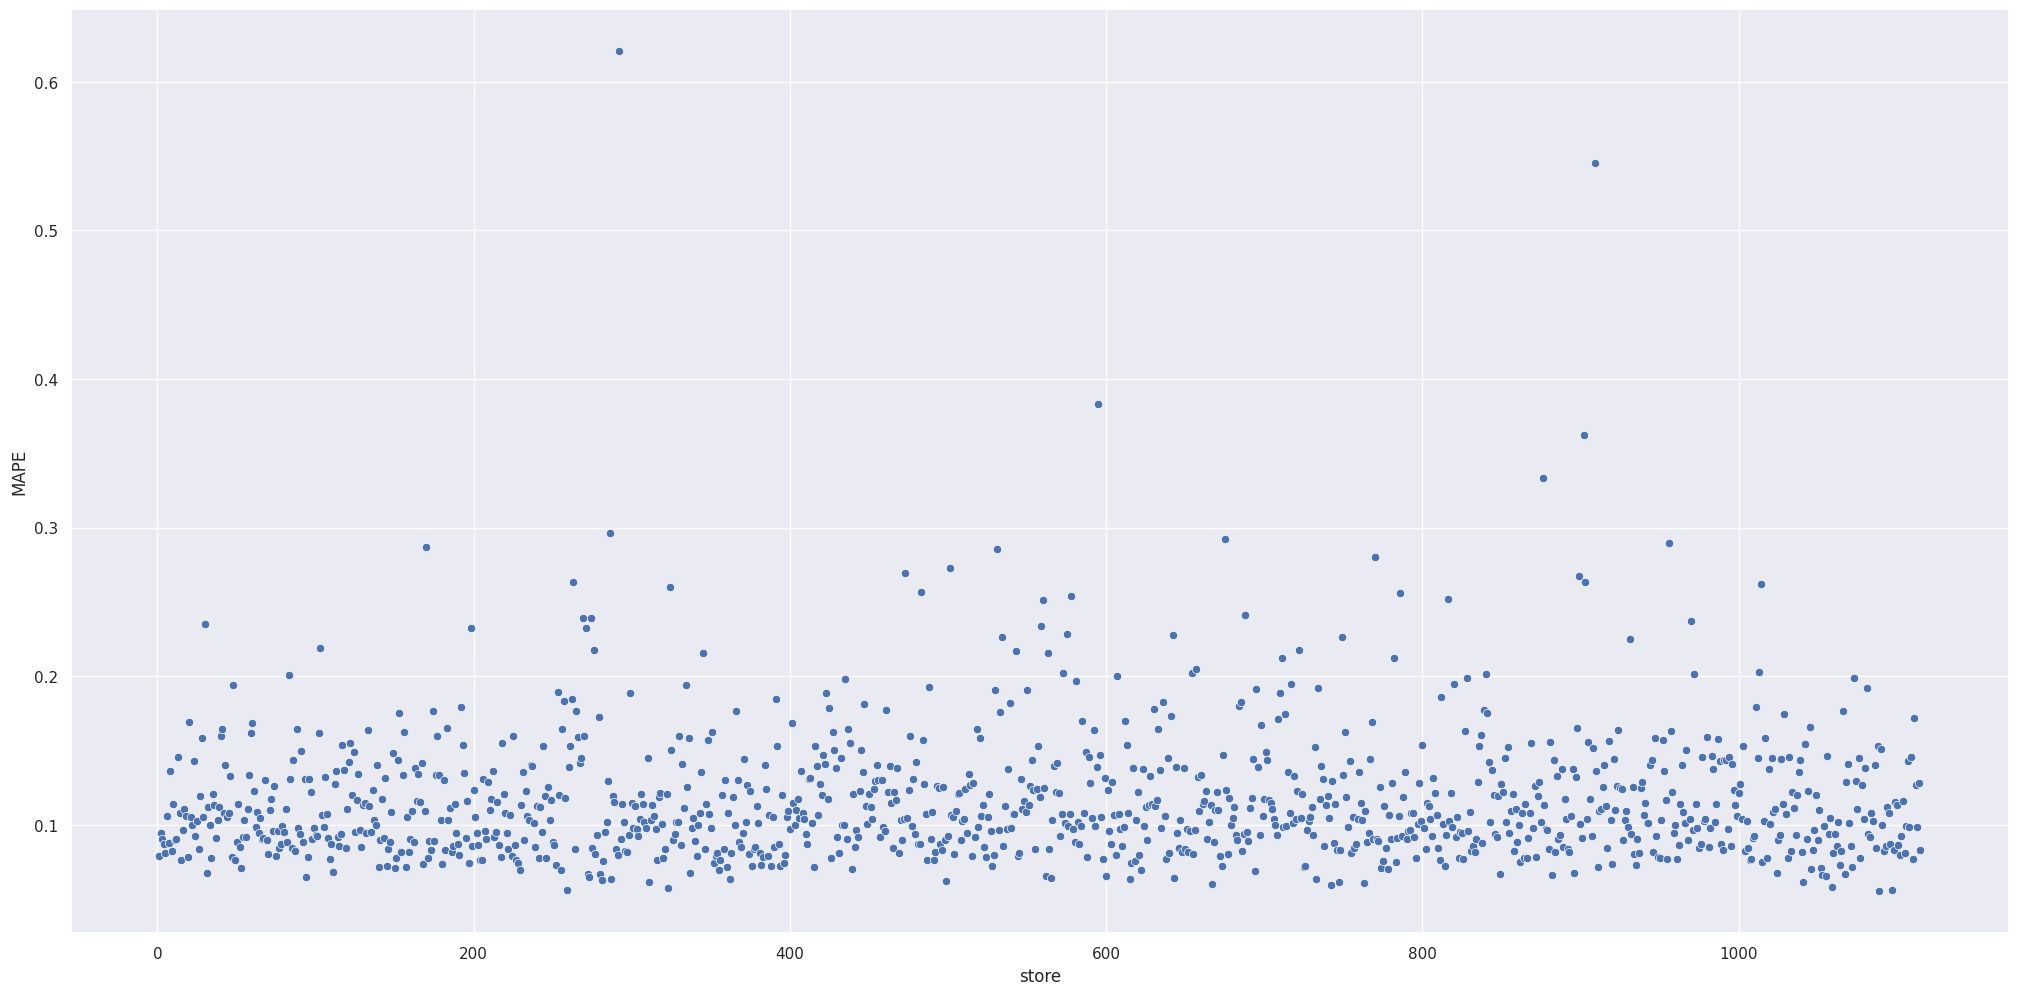

In [109]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

##  9.2. Total Performance

In [110]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$276,575,296.00"
1,worst_scenario,"R$275,699,104.58"
2,best_scenario,"R$277,451,489.12"


## 9.3. Machine Learning Performance

In [111]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

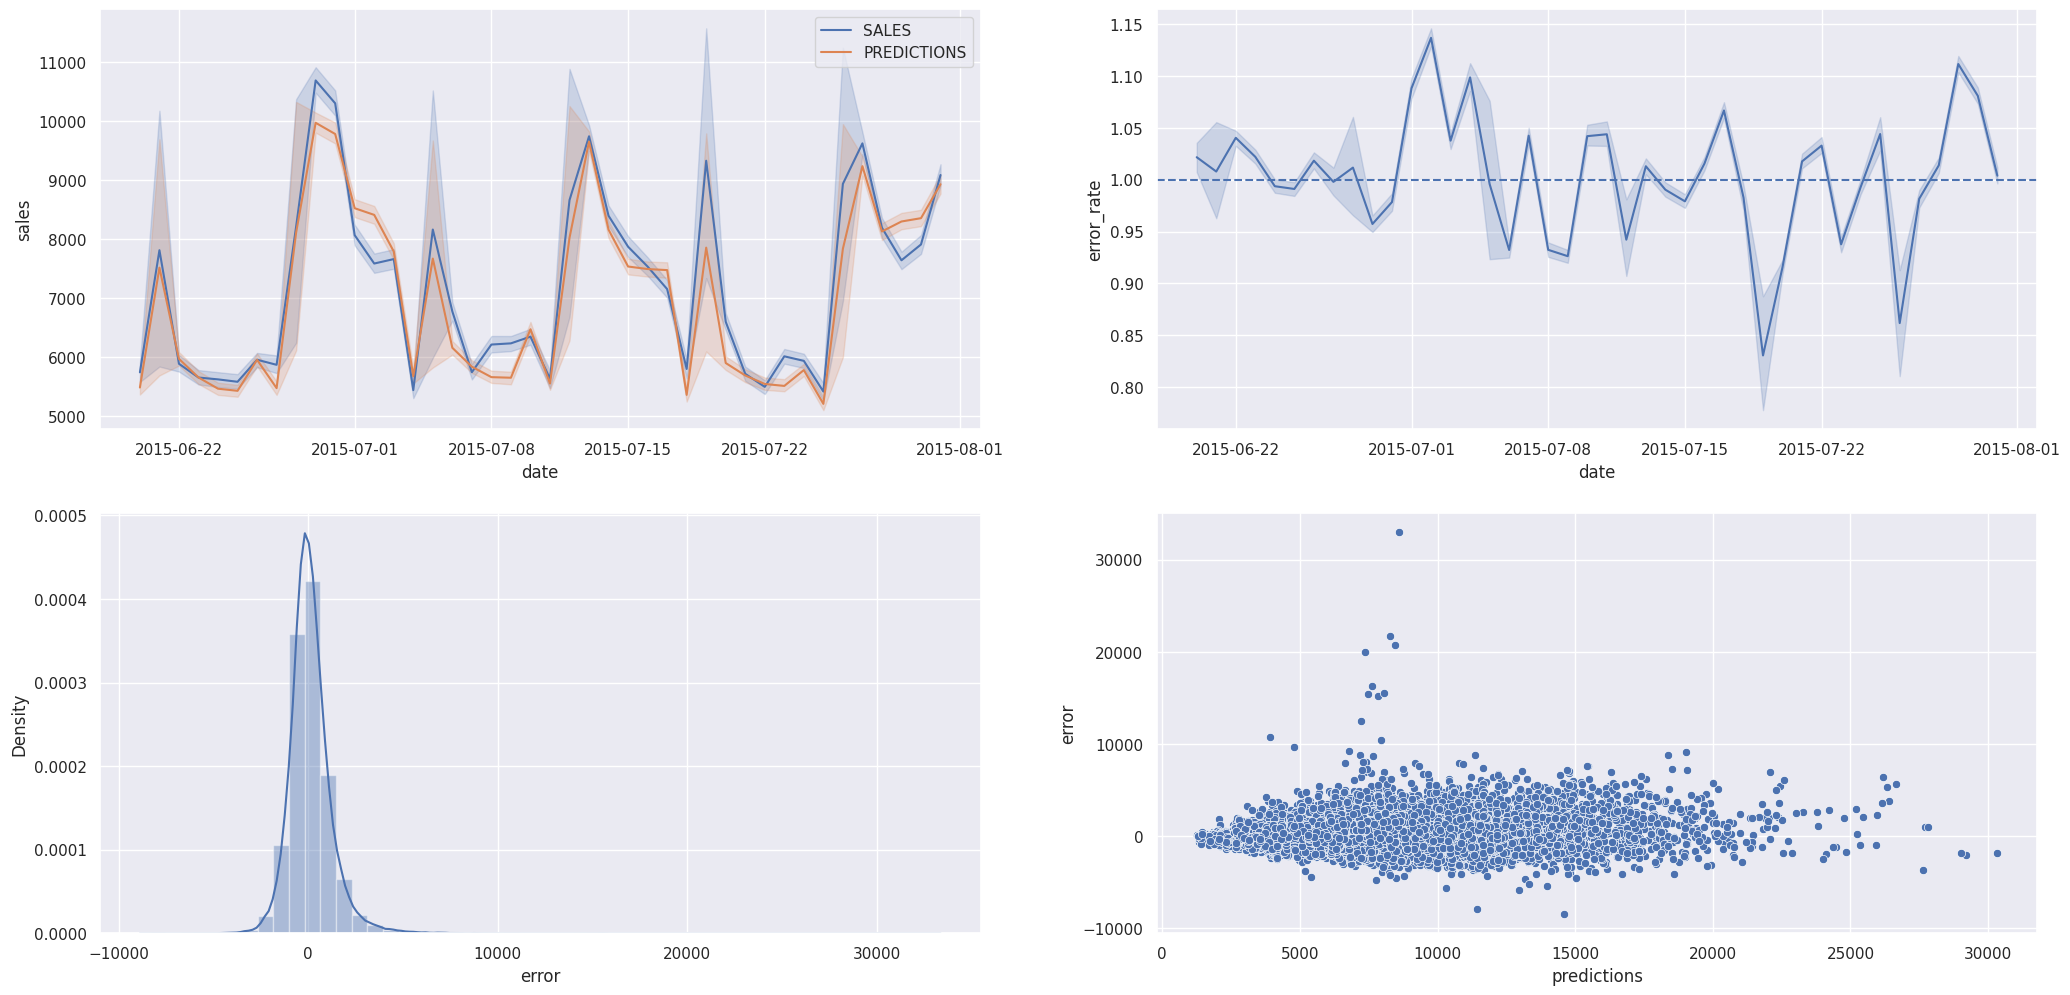

In [112]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['predictions'], y=df9['error'], data=df9  )

# 10.0 DEPLOY MODEL TO PRODUCTION (Passo 10)

In [113]:
# # Save Trained Model
# pickle.dump( model_xgb_tuned, open('/content/drive/My Drive/ProjetoDSProducao/model/model_rossman.pkl', 'wb' ))

In [114]:
import pickle
# Save Trained Model
pickle.dump( model_xgb_tuned, open('/home/ds_producao/model/model_rossmann.pkl', 'wb' ))

FileNotFoundError: [Errno 2] No such file or directory: '/home/ds_producao/model/model_rossmann.pkl'

## 10.1 Rossman class

In [115]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    '''A classe Rossmann é um conjunto de métodos para manipulação, limpeza e preparação de dados para um modelo preditivo, além de realizar previsões.
    Seus métodos incluem desde a limpeza e transformação dos dados até a preparação final para a previsão.
    Isso envolve ajustes nos tipos de dados, criação de novas features, escalonamento, codificação de variáveis categóricas e geração de previsões a
    partir de um modelo treinado.

    Input:
    1. df1, df2, df5: DataFrames com dados para limpeza, engenharia de features e preparação, respectivamente.
    2. model: Modelo de machine learning treinado.
    3. original_data: Dados originais para os quais as previsões serão incorporadas.
    4. test_data: Dados de teste para gerar previsões.

    Output:

    Métodos de limpeza, engenharia de features e preparação retornam DataFrames processados.
    get_prediction() retorna os dados originais com uma nova coluna contendo as previsões do modelo em formato JSON.

    Esses métodos encapsulam etapas comuns em pipelines de pré-processamento e previsão de modelos de machine learning aplicados ao contexto
    específico da previsão de vendas da Rossmann.
    '''
    def __init__( self ):
        '''Esta função __init__ da classe Rossmann é um método especial que é chamado quando uma instância da classe é criada.
        Ela é responsável por inicializar os atributos da classe, configurando os caminhos dos arquivos e carregando os scalers necessários para o
        pré-processamento dos dados no contexto do modelo de previsão de vendas da Rossmann.

        Input: Não recebe input direto, mas depende dos arquivos presentes no caminho definido em self.home_path.
        Output:

        Atributos da classe Rossmann são inicializados, contendo os scalers carregados a partir dos arquivos específicos definidos no caminho self.home_path.
        Estes scalers são utilizados em etapas posteriores de pré-processamento e transformação dos dados para o modelo de previsão.
        '''
        self.home_path='/home/ds_producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )

    def data_cleaning( self, df1 ):
        '''A função data_cleaning na classe Rossmann realiza diversas operações de pré-processamento nos dados para padronizá-los e prepará-los para análise.
        Isso inclui a renomeação de colunas para o formato snake_case, conversão de tipos de dados (como a coluna 'date' para datetime), preenchimento de
        valores ausentes em algumas colunas específicas ('competition_distance', 'competition_open_since_month', 'competition_open_since_year',
        'promo2_since_week', 'promo2_since_year', 'promo_interval'), e criação de novas features com base nas colunas existentes.

        Input: Recebe um DataFrame df1 contendo os dados a serem limpos e preparados.

        Output: Retorna o DataFrame df1 após a aplicação das transformações de limpeza e pré-processamento.
        Este DataFrame estará pronto para ser usado em etapas subsequentes, como engenharia de features ou modelagem.
        '''
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA

        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        return df1

    def feature_engineering( self, df2 ):
        '''A função feature_engineering na classe Rossmann realiza a criação e transformação de features nos dados, adicionando informações relevantes que
        podem ajudar no processo de modelagem. Esta função inclui a extração de informações temporais (como ano, mês, dia, semana do ano), cálculos de tempo
        desde eventos específicos (como a competição desde a abertura da loja), e transformações de variáveis categóricas para representações numéricas mais
        úteis.

        Input: Recebe um DataFrame df2 contendo os dados a serem processados e enriquecidos com novas features.

        Output: Retorna o DataFrame df2 após a aplicação das transformações de engenharia de features. Este DataFrame terá colunas adicionais que capturam
        informações temporais, calculadas a partir dos dados existentes, e outras features derivadas para melhorar o desempenho do modelo de previsão.
        '''
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x =='a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )

        return df2

    def data_preparation( self, df5 ):
        '''A função data_preparation na classe Rossmann executa o processo final de preparação dos dados, realizando escalonamento de variáveis numéricas,
        codificação de variáveis categóricas e criação de novas features para serem utilizadas no modelo de previsão.
        Essa etapa é fundamental para garantir que os dados estejam formatados corretamente e prontos para serem usados no treinamento do modelo.

        Input: Recebe um DataFrame df5 que contém os dados após passarem por etapas anteriores de limpeza e engenharia de features.

        Output: Retorna um DataFrame com as colunas selecionadas e as transformações finais aplicadas, pronto para ser utilizado no treinamento do modelo
        de machine learning. Essas transformações incluem escalonamento de variáveis numéricas, codificação de variáveis categóricas e a geração de features
        adicionais para enriquecer os dados.
        '''
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values )

        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'],columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * ( 2. * np.pi/52 ) ) )

        cols_selected = [ 'store', 'promo', 'store_type', 'assortment','competition_distance', 'competition_open_since_month',
                          'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
                          'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos','day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

        return df5[ cols_selected ]

    def get_prediction( self, model, original_data, test_data ):
        '''A função get_prediction na classe Rossmann é responsável por gerar previsões usando um modelo treinado e incorporar essas previsões aos dados
        originais. Ela recebe o modelo treinado, os dados originais e os dados de teste, executa a previsão usando o modelo nos dados de teste e junta essas
        previsões ao conjunto de dados original.

        Input:

        1. model: Modelo de machine learning previamente treinado.
        2. original_data: Dados originais aos quais as previsões serão adicionadas.
        3. test_data: Dados de teste nos quais o modelo fará previsões.

        Output: Retorna um JSON contendo os dados originais com uma nova coluna chamada 'prediction', que contém as previsões feitas pelo modelo para os dados
        de teste. Este formato permite uma fácil visualização das previsões associadas aos dados originais. Esses dados estão prontos para serem analisados ou
        utilizados em outras aplicações.
        '''
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' )



## 10.2 API Handler

In [ ]:
import pickle
import requests
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/ds_producao/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    '''A função rossmann_predict é uma função de roteamento em uma aplicação web usando o framework Flask que processa solicitações de previsão para
    um modelo Rossmann. Ela recebe dados de teste em formato JSON, limpa, executa engenharia de features, prepara os dados e realiza previsões usando
    um modelo previamente treinado da classe Rossmann.

    Input:

    1. Dados de teste em formato JSON, recebidos por meio de uma solicitação web (solicitação POST).
    2. model: Modelo de machine learning previamente treinado.

    Output:

    1. Retorna um JSON contendo os dados originais com uma nova coluna chamada 'prediction', que contém as previsões feitas pelo modelo para os dados de teste.
    2. Caso não haja dados de teste, retorna uma resposta vazia em formato JSON com status 200.

    A função é projetada para ser integrada a um servidor web, onde a rota '/rossmann_predict' manipula as solicitações de previsão enviadas para esse
    endpoint específico.
    '''
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )

        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response

    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )



## 10.3 API Tester

In [ ]:
# loading test dataset in local linux
df10 = pd.read_csv( '/home/ds_producao/datasets/test.csv' )

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [99, 117, 235] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
# url = ' http://127.0.0.1:5000/rossmann/predict'
url = 'https://teste-api-hender-dsproducao.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )


In [ ]:
d2